In [1]:
import numpy as np
import pylab as plt
#from numpy import fft
import healpy as hp
from astropy.cosmology import Planck15, default_cosmology
from astropy import constants as const
from astropy import units as un
from astropy.coordinates import SkyCoord
import h5py
from scipy import signal
from astropy.io import ascii, fits

fft = np.fft.fft
fft2 = np.fft.fft2
ifft2 = np.fft.ifft2
fftshift = np.fft.fftshift
ifftshift = np.fft.ifftshift

## Defining the cosmology - Planck15 of astropy 
cosmo = Planck15
f21 = 1420.405752 * un.MHz # MHz
c = const.c.value # m/s
print('The 21 cm line emission freq - ',f21)

The 21 cm line emission freq -  1420.405752 MHz


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
%matplotlib inline

plt.rc('font', family='serif', weight='normal', size=22.0)
# plt.rc('xtick', labelsize='x-small')
# plt.rc('ytick', labelsize='x-small')

import copy
COLORMAP = copy.copy(matplotlib.cm.__dict__["inferno"])
COLORMAP.set_under("black")
COLORMAP.set_bad("lightgray")

In [3]:
import os

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


In [4]:
# Define all the functions here

def delay_to_kpara(delay, z, cosmo=None):
    """Conver delay in sec unit to k_parallel (comoving 1./Mpc along line of sight).

    Parameters
    ----------
    delay : Astropy Quantity object with units equivalent to time.
        The inteferometric delay observed in units compatible with time.
    z : float
        The redshift of the expected 21cm emission.
    cosmo : Astropy Cosmology Object
        The assumed cosmology of the universe.
        Defaults to planck2015 year in "little h" units

    Returns
    -------
    kparr : Astropy Quantity units equivalent to wavenumber
        The spatial fluctuation scale parallel to the line of sight probed by the input delay (eta).

    """

    
    if cosmo is None:
        cosmo = default_cosmology.get()
    return (delay * (2 * np.pi * cosmo.H0 * f21 * cosmo.efunc(z))
            / (const.c * (1 + z)**2)).to('1/Mpc')

def kpara_to_delay(kpara, z, cosmo=None):
    """Convert k_parallel (comoving 1/Mpc along line of sight) to delay in sec.

    Parameters
    ----------
    kpara : Astropy Quantity units equivalent to wavenumber
        The spatial fluctuation scale parallel to the line of sight
    z : float
        The redshift of the expected 21cm emission.
    cosmo : Astropy Cosmology Object
        The assumed cosmology of the universe.
        Defaults to WMAP9 year in "little h" units

    Returns
    -------
    delay : Astropy Quantity units equivalent to time
        The inteferometric delay which probes the spatial scale given by kparr.

    """

    
    if cosmo is None:
        cosmo = default_cosmology.get()
    return (kpara * const.c * (1 + z)**2
            / (2 * np.pi * cosmo.H0 * f21 * cosmo.efunc(z))).to('s')

def kperp_to_u(kperp, z, cosmo=None):
    """Convert comsological k_perpendicular to baseline length u (wavelength unit).

    Parameters
    ----------
    kperp : Astropy Quantity units equivalent to wavenumber
        The spatial fluctuation scale perpendicular to the line of sight.
    z : float
        The redshift of the expected 21cm emission.
    cosmo : Astropy Cosmology Object
        The assumed cosmology of the universe.
        Defaults to WMAP9 year in "little h" units

    Returns
    -------
    u : float
        The baseline separation of two interferometric antennas in units of
        wavelength which probes the spatial scale given by kperp

    """
    if cosmo is None:
        cosmo = default_cosmology.get()
    return kperp * cosmo.comoving_transverse_distance(z) / (2 * np.pi)

def u_to_kperp(u, z, cosmo=None):
    """Convert baseline length u to k_perpendicular.

    Parameters
    ----------
    u : float
        The baseline separation of two interferometric antennas in units of wavelength
    z : float
        The redshift of the expected 21cm emission.
    cosmo : Astropy Cosmology Object
        The assumed cosmology of the universe.
        Defaults to WMAP9 year in "little h" units

    Returns
    -------
    kperp : Astropy Quantity units equivalent to wavenumber
        The spatial fluctuation scale perpendicular to the line of sight probed by the baseline length u.

    """
    if cosmo is None:
        cosmo = default_cosmology.get()
    return 2 * np.pi * u / cosmo.comoving_transverse_distance(z)

def get_spatial_kmodes(Nx,Ny,theta_res,edshift):
    """Estimate the spatial fourier k-modes, (kx and ky) and the gridded u,v coordinates.  
    
    Parameteres
    -----------
    Nx : int
     Number of cells along RA or X-axis direction.
    Ny : int
      Number of cells along DEC or Y-axis direction.
    theta_res : float 
      The cell size of the map in radian unit.
    redshift : float
      redshift at the centre of the band.
    
    Returns
    -------
    k_x : np.ndarray[nra]
     spatial fourier modes along X-axis 
    k_y : np.ndarray[nel]
     spatial fourier modes along Y-axis
    u : np.ndarray[nra]
     gridded u-coordinates 
    v : np.ndarray[nel]
     gridded v-coordinates
    """
    DMz = cosmo.comoving_transverse_distance(redshift).value # in Mpc
    dtheta_Mpc =  DMz * theta_res   # res (radian) to Mpc unit
    k_x = 2*np.pi * (np.fft.fftfreq(Nx, d=dtheta_Mpc)) # [Mpc^-1] The kx coordinates along the X-direction
    k_y = 2*np.pi * (np.fft.fftfreq(Ny, d=dtheta_Mpc)) # [Mpc^-1] The ky coordinates along the Y-direction
   
    k_x = np.fft.fftshift(k_x)
    k_y = np.fft.fftshift(k_y)
    
    u = (DMz * k_x)/(2*np.pi)
    v = (DMz * k_y)/(2*np.pi)
    return k_x,k_y, u, v

def jy_per_beam_to_kelvin(freq,beam_area=1.0):
    """Conversion factor from Jy/beam to kelvin unit.
    
    The conversion factor is C = (10**-26 * lambda**2)/(2 * K_boltzmann * omega_PSF), 
    where omega_PSF is the beam area in sr unit.
    
    Parameters
    ----------
    freq : np.ndarray[nfreq]
        frequency in MHz unit
    beam_area : float
        synthesized beam area in sr unit
        
    Returns
    -------
    C : np.ndarray[nfreq]
     The conversion factor from Jy/beam to Kelvin
    """
 
    Jy = 1.0e-26 # W m^-2 Hz^-1
    c = const.c.value # m/s
    wl = c/(freq*1e6) # freq of the map in MHz
    kB = const.k_B.value # Boltzmann Const in J/k (1.38 * 10-23)
    C = (wl**2 * Jy) / (2*kB *beam_area.value)
    return C 

def image_to_uv(data_cube,window=True,window_name ='tukey', alpha=0.5, axes=None):
    """Spatial FFT along RA and DEC axes of the data cube.
    
    Parameters
    ----------
    data_cube : np.ndarray[nfreq,nra,nel]
       The data cube, whose spatial FFT will be computed along RA and DEC axes.
    window : bool.
       If True apply a spatial apodisation function. Default: True.
    window_name : 'Tukey'
       Apply Tukey spatial tapering window. Default: 'Tukey'.
    alpha : float 
       Shape parameter of the Tukey window. 
       0 = rectangular window, 1 = Hann window. We are taking 0.5 (default), which lies in between. 
    axes : Tuple.
      The axes along which to do the 2D Spatial FFT. This is the RA and DEC axex of the data cube. 
      
    Returns
    -------
      data_cube : np.ndarray[nfreq,nra,nel]
         The 2D spatial FFT of the data cube in (u,v) domain.
    """
    from scipy.signal import windows
    FT_norm = 1 / float(np.prod(np.array(data_cube.shape)[list(axes)]))
    print(f"Fourier Norm : {FT_norm}")            
    if window:
        window_func = getattr(windows, window_name)
        w_ra = window_func(data_cube.shape[axes[0]],alpha=alpha)   # taper in the RA direction 
        w_dec = window_func(data_cube.shape[axes[1]],alpha=alpha)  # taper in the DEC direction
        taper_window = np.outer(w_ra[:,np.newaxis],w_dec[np.newaxis,:]) # Make the 2D tapering function by taking the outer product 
        print(f'Taper window shape : {taper_window.shape}')
        data_cube *=  taper_window[np.newaxis,:,:]
              
    uv_map = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(data_cube, axes=axes), axes=axes), axes=axes)
     
    return uv_map * FT_norm

def get_ps(vis_cube_1, vis_cube_2 , vol_norm_factor):
    """Estimate the cross-correlation of two data cubes,
    and normalize it. If a single data cube is 
    provided, then estimate the auto-correlation.
    
    The data cubes are complex. This will estimate the cross-correlation
    of two complex data cubes and return the real part of that.
    
    Parameters
    ----------
    vis_cube_1 : np.ndarray[nfreq,Nx,Ny]
      complex data cube in (tau,u,v) domain.
    vis_cube_2 : np.ndarray[nfreq,Nx,Ny]
      complex data cube in (tau,u,v) domain. 
    vol_norm_factor : float
      power spectrum normalization factor in [Mpc^3]
    
    Return
    ------
    ps_cube_real: np.ndarray[nfreq,Nx,Ny]
       The real part of the power spectrum
    """
    if vis_cube_1 is None and vis_cube_2 is None:
        raise NameError('Atleast one map must be provided')
      
    if vis_cube_2 is None:
        print('correlate the vis cube with itself')
        ps_cube_real = (np.conj(vis_cube_1) * vis_cube_1).real
        
    else:
        print('correlate the vis cube 1 with vis cube 2')
        ps_cube_real = (vis_cube_1 * np.conj(vis_cube_2)).real
        
    return ps_cube_real*vol_norm_factor

def is_odd(num):
    return num & 0x1

def PS2D(ps_cube,weight_cube,kperp_bins,kpar_bins,kpar,uu,vv,redshift,fold=True):
    """Estimate the cylindrically averaged 2D power spectrum. 
    
     Parameters
     ----------
     ps_cube : np.ndarray[nfreq,nra*nel] 
       The power spectrum array to average in cylindrical bins.
     weight_cube : np.ndarray[nfreq,nra,nel]
       The inverse variance weight, to be used in averaging. 
     kperp_bins : list
       The bin values provided by the SKA group.
     kpar_bins : list
       The bin values provided by the SKA group.
     kpar : np.ndarray[nfreq]
       The k_parallel array, unit 1/Mpc 
     uu : np.ndarray[nra]
      The u-coordinate in wavelength.
     vv : np.ndarray[nel] 
       The v-coordinate in wavelength.
     redshift : float
       The redshift corresponding to the band center.
     fold: bool
       fold the negative delay modes
    Returns
    -------
    ps_2D : np.ndarray[]
      The cylindrically avg 2D Power of shape (k_par,k_perp) with unit [K^2 Mpc^3] 
    k_perp : np.array[Nbins_2d]
     The k_perp array after binning.
    k_para : np.array[nfreq//2]
     The k_parallel array, only the positive half. 
    """
    
   
    # Set weights
    
    if weight_cube is not None:
        # Inverse variance weighting, here weight_cube = 1/sigma, so we are squaring it to get variance
        print('Using inverse variance weighting')
        w = weight_cube ** 2 
    else:
        print('Using unit uniform weighting')
        w = np.ones_like(ps_cube) # Unit uniform weight.  
        
                                
    kp = kperp_bins
    # Find the bin indices and determine which radial bin each cell lies in.

    ku = u_to_kperp(uu,redshift) #convert the u-array to fourier modes
    kv = u_to_kperp(vv,redshift) #convert the v-array to fourier modes
    
    ru = np.sqrt(ku.value** 2 + kv.value ** 2) 
    
    # Digitize the bins
    bin_indx = np.digitize(ru, bins=kp) 
    print(bin_indx.shape)
    
    # Define empty list to store the binned 2D PS
    
    ps_2D = []
    ps_2D_err = [] 
    ps_2D_w = []
    
    # Now bin in 2D ##
    with np.errstate(divide='ignore', invalid='ignore'):
        for i in np.arange(len(kp)) + 1:
            p = np.nansum(w[:, bin_indx == i] * ps_cube[:, bin_indx == i], axis=1) / np.sum(w[:, bin_indx == i], axis=1)
            p_err = np.sqrt(2 * np.sum(w[:, bin_indx == i] ** 2 * p[:, None] **
                                       2, axis=1) / np.sum(w[:, bin_indx == i], axis=1) ** 2)

            ps_2D.append(p)
            ps_2D_err.append(p_err)
            ps_2D_w.append(np.sum(w[:, bin_indx == i], axis=1))
            
    ps_2D =  np.array(ps_2D).T 
    ps_2D_w =  np.array(ps_2D_w).T
    ps_2D_err = np.array(ps_2D_err).T

    if fold:
        M = len(kpar)
        k_par = kpar[M // 2 + 1:]
        if is_odd(M):
            ps2D_fold = 0.5 * (ps_2D[M // 2 + 1:] + ps_2D[:M // 2][::-1])
            ps2D_err_fold = 0.5 * np.sqrt(ps_2D_err[M // 2 + 1:] ** 2 + ps_2D_err[:M // 2][::-1] ** 2)
            ps2D_w_fold = ps_2D_w[M // 2 + 1:] + ps_2D_w[:M // 2][::-1]
        else:
            ps2D_fold = 0.5 * (ps_2D[M // 2 + 1:] + ps_2D[1:M // 2][::-1])
            ps2D_err_fold = 0.5 * np.sqrt(ps_2D_err[M // 2 + 1:] ** 2 + ps_2D_err[1:M // 2][::-1] ** 2)
            ps2D_w_fold = ps_2D_w[M // 2 + 1:] + ps_2D_w[1:M // 2][::-1]

    # Digitize the kpar bins
    bin_indx_kpar = np.digitize(k_par, bins=kpar_bins)
    ps_2d = []
    ps_2d_err = [] 
    ps_2d_w = []
    
    # Now bin in kpar ##
    with np.errstate(divide='ignore', invalid='ignore'):
        for i in np.arange(len(kpar_bins)) + 1:
            p = np.nansum(ps2D_w_fold[bin_indx_kpar == i,:] * ps2D_fold[bin_indx_kpar == i,:], axis=0) / np.sum(ps2D_w_fold[bin_indx_kpar == i,:], axis=0)
            
            p_err = np.sqrt(2 * np.sum(ps2D_w_fold[bin_indx_kpar == i,:] ** 2 * p[None,:] **
                                       2, axis=0) / np.sum(ps2D_w_fold[bin_indx_kpar == i,:], axis=0) ** 2)

            ps_2d.append(p)
            ps_2d_err.append(p_err)
            ps_2d_w.append(np.sum(ps2D_w_fold[bin_indx_kpar == i,:], axis=0))
        
    return kp, kpar_bins, np.array(ps_2d), np.array(ps_2d_w), np.array(ps_2d_err)

def PS2D_no_kpar_bin(ps_cube,weight_cube,kperp_min,kperp_max,kpar,uu,vv,redshift,fold=True,
                    Nbins_2D=30,log_bins=False):
    """Estimate the cylindrically averaged 2D power spectrum. 
    
     Parameters
     ----------
     ps_cube : np.ndarray[nfreq,nra*nel] 
       The power spectrum array to average in cylindrical bins.
     weight_cube : np.ndarray[nfreq,nra,nel]
       The inverse variance weight, to be used in averaging. 
     kperp_min : float
       The min value of the bin in k-perpendicular direction; unit 1/Mpc 
     kperp_min : float
       The max value of the bin in k-perpendicular direction; unit 1/Mpc 
     kpar : np.ndarray[nfreq]
       The k_parallel array, unit 1/Mpc 
     uu : np.ndarray[nra]
      The u-coordinate in wavelength.
     vv : np.ndarray[nel] 
       The v-coordinate in wavelength.
     redshift : float
       The redshift corresponding to the band center.
     fold: bool
       fold the negative delay modes if True.
     Nbins_2D : int
       The number of bins in k-perpendicualr direction
     log_bins : bool
       Bins in logarithmic space. Default : True. 
            
    Returns
    -------
    ps_2D : np.ndarray[] 
      The cylindrically avg 2D Power of shape (k_par,k_perp) with unit [K^2 Mpc^3] 
    k_perp : np.array[Nbins_2d]
     The k_perp array after binning.
    k_para : np.array[nfreq//2]
     The k_parallel array, only the positive half. 
    """
    
   
    # Set weights
    
    if weight_cube is not None:
        # Inverse variance weighting, here weight_cube = 1/sigma, so we are squaring it to get variance
        print('Using inverse variance weighting')
        w = weight_cube ** 2 
    else:
        print('Using unit uniform weighting')
        w = np.ones_like(ps_cube) # Unit uniform weight.  
        
        
    # Choosing the bins
    if log_bins:
        print(f'Using logarithmic binning in k_perp between {kperp_min} and {kperp_max}')
        kp = np.logspace(np.log10(kperp_min), np.log10(kperp_max),Nbins_2D+1) 
    else:
        print(f'Using linear binning in k_perp between {kperp_min} and {kperp_max}')
        kp = np.linspace(kperp_min, kperp_max,Nbins_2D+1)
                                 
   # kp = kperp_bins
    # Find the bin indices and determine which radial bin each cell lies in.

    ku = u_to_kperp(uu,redshift) #convert the u-array to fourier modes
    kv = u_to_kperp(vv,redshift) #convert the v-array to fourier modes
    
    ru = np.sqrt(ku.value** 2 + kv.value ** 2) 
    
    # Digitize the bins
    bin_indx = np.digitize(ru, bins=kp) 
    print(bin_indx.shape)
    
    # Define empty list to store the binned 2D PS
    
    ps_2D = []
    ps_2D_err = [] 
    ps_2D_w = []
    
    # Now bin in 2D ##
    with np.errstate(divide='ignore', invalid='ignore'):
        for i in np.arange(len(kp)) + 1:
            p = np.nansum(w[:, bin_indx == i] * ps_cube[:, bin_indx == i], axis=1) / np.sum(w[:, bin_indx == i], axis=1)
            p_err = np.sqrt(2 * np.sum(w[:, bin_indx == i] ** 2 * p[:, None] **
                                       2, axis=1) / np.sum(w[:, bin_indx == i], axis=1) ** 2)

            ps_2D.append(p)
            ps_2D_err.append(p_err)
            ps_2D_w.append(np.sum(w[:, bin_indx == i], axis=1))
            
    ps_2D =  np.array(ps_2D).T 
    ps_2D_w =  np.array(ps_2D_w).T
    ps_2D_err = np.array(ps_2D_err).T

    if fold:
        M = len(kpar)
        k_par = kpar[M // 2 + 1:]
        if is_odd(M):
            ps2D_fold = 0.5 * (ps_2D[M // 2 + 1:] + ps_2D[:M // 2][::-1])
            ps2D_err_fold = 0.5 * np.sqrt(ps_2D_err[M // 2 + 1:] ** 2 + ps_2D_err[:M // 2][::-1] ** 2)
            ps2D_w_fold = ps_2D_w[M // 2 + 1:] + ps_2D_w[:M // 2][::-1]
        else:
            ps2D_fold = 0.5 * (ps_2D[M // 2 + 1:] + ps_2D[1:M // 2][::-1])
            ps2D_err_fold = 0.5 * np.sqrt(ps_2D_err[M // 2 + 1:] ** 2 + ps_2D_err[1:M // 2][::-1] ** 2)
            ps2D_w_fold = ps_2D_w[M // 2 + 1:] + ps_2D_w[1:M // 2][::-1]
            
        return kp, k_par, np.array(ps2D_fold), np.array(ps2D_w_fold), np.array(ps2D_err_fold) 

        
    return kp, kpar, np.array(ps_2d), np.array(ps_2d_w), np.array(ps_2d_err)

def reshape_data_cube(data_cube,u,v,bl_min,bl_max):
    """Keep non-zero visibility cube between min and max baslines (in wavelength unit).
    
    For each delay channel, it will keep the non-zero visibilities between min and max 
    baseline length and flatten the array.
    
    Parameters
    ----------
    data_cube : np.ndarray[nfreq,Nx,Ny]
     The data cube to reshape and flatten.
    u : np.ndarray[Nx]
     The u-coordinates in wavelength unit.
    v : np.ndarray[Ny]
     The v-coordinates in wavelength unit. 
    bl_min : float
     The min baseline length in wavelength unit.
    bl_max : float
     The max baseline length in wavelength unit.
     
    Returns
    -------
    ft_cube : np.ndarray[nfreq,nvis]
     The flatten data cube.
    uu : np.ndarray[nvis]
     The flatten u-coordinates
    vv : np.ndarray[nvis]
     The flatten v-coordinates
    """
    g_uu, g_vv = np.meshgrid(v, u)
    print(f'Gridded data cube shape in kx and ky direction - {g_uu.shape}') 
    g_ru = np.sqrt(g_uu ** 2 + g_vv ** 2)
    bl_idx = (g_ru >= bl_min) & (g_ru <= bl_max)
    uu = g_uu[bl_idx]
    vv = g_vv[bl_idx] 
    
    ft_cube = []
    for ii in range(data_cube.shape[0]):
        ft = data_cube[ii,:,:]
        ft_cube.append(ft[bl_idx].flatten())
        
    return np.array(ft_cube),uu.flatten(), vv.flatten() 

def vol_normalization_vis(Nx,Ny,Nz,theta_res,redshift,chan_width):
    """Estimate the volume normalization factor for the power spectrum.
    
    Parameters
    ----------
    Nx : int
     Number of cells along RA or X-axis direction.
    Ny : int
      Number of cells along DEC or Y-axis direction.
    Nz : int
      Number of samples along freq or Z- axis direction.
    theta_res : float 
      The cell size  in radian unit.
    redshift : float
      redshift at the centre of the band.
    chan_width : float
       channel width in MHz unit.
    
    Returns
    -------
    norm : float
      The  PS normalization factor in Mpc^3 unit
    """
    DMz = cosmo.comoving_transverse_distance(redshift).value # in Mpc
    
    # Along spatial direction 
    dtheta_Mpc =  DMz * theta_res  # res (radian) to Mpc unit
    Lx = (Nx*dtheta_Mpc)  #survey length in RA/X-axis [Mpc]
    Ly = (Ny*dtheta_Mpc) # survey length in DEC/Y-axis [Mpc]
     
    ## Along line-of-sight direction  
    f21 = 1420.405752 * un.MHz # MHz
    c = const.c.to("km/s").value # [km/s]
    Hz = cosmo.H(redshift).value  # [km/s/Mpc]
    d_z = c * (1+redshift)**2 * chan_width / Hz / f21.value  #[Mpc] The sampling interval along the Z line-of-sight dimension Reference: Ref.[liu2014].Eq.(A9)
    Lz = d_z * Nz  #The linear size in z-direction [Mpc]
    

    print(f'Linear size in X-direction = {Lx} Mpc')
    print(f'Linear size in Y-direction = {Ly} Mpc')
    print(f'Linear size in Z-direction = {Lz} Mpc')
    
    norm = (Lx * Ly * Lz)
    print(f'Power Spectrum normalization factor  value - {norm} Mpc^3')
    
    return norm


# Load Data

In [9]:
path = '/project/def-mdobbs/arnab92/SKAD3/data/natural_sub_bands'
data_u = os.path.join(path,'SKA_data_sub_1_106_120.9_MHz.fits')

In [10]:
hdu = fits.open(data_u)[0]

In [11]:
hdr = hdu.header

In [12]:
#hdr

In [13]:
image = np.array(hdu.data[:])

In [14]:
nfreq, Nx, Ny = image.shape

In [15]:
nfreq,Nx, Ny

(150, 2048, 2048)

In [16]:
# Freq array of the data
freq0 = hdr.get('CRVAL3') # First freq channel value in Hz
chan_res = hdr.get('CDELT3') # chan res in Hz
freq = freq0 + chan_res * (np.arange(nfreq)) # The freq array in Hz
print(f"freq range : {freq[0]/1e6} to {freq[-1]/1e6} MHz")
print(f" Chan res : {chan_res/1e6} MHz")

freq range : 106.0 to 120.9 MHz
 Chan res : 0.1 MHz


In [17]:
# Resolution of the image
dx = hdr.get('CDELT1') # pixel size in X-direction, in deg
dy = hdr.get('CDELT2') # pixel size in Y-direction , in deg
print(f'pixel size in X and Y directions are, dx:{abs(dx*3600)} arcsec and dy:{abs(dy*3600)} arcsec')

pixel size in X and Y directions are, dx:15.999999999999984 arcsec and dy:15.999999999999984 arcsec


In [18]:
# freq_start = hdr['CRVAL3']
# df = hdr['CDELT3']
# nf = hdr['NAXIS3']
# freq_end = freq_start + (nf - 1) * df
# fits_freqs = np.linspace(freq_start, freq_end, nf)


In [19]:
DEC_c = hdr.get('CRVAL2')
RA_c = hdr.get('CRVAL1')
cdelta2 = hdr.get('CDELT2')
cdelta1 = hdr.get('CDELT1')
DEC = np.arange((DEC_c-(cdelta2*Ny/2.)) , (DEC_c+(cdelta2*Ny/2.)), cdelta2)
RA = np.arange((RA_c-(cdelta1*Nx/2.)) , (RA_c+(cdelta1*Nx/2.)), cdelta1)

print(f'RA size: {RA.size} and DEC size {DEC.size}')

print(f"RA range : {RA[0]} to {RA[-1]}")
print(f"DEC range : {DEC[0]} to {DEC[-1]}")

RA size: 2048 and DEC size 2048
RA range : 4.551111111111107 to -4.546666666666274
DEC range : -34.551111111111105 to -25.453333333331905


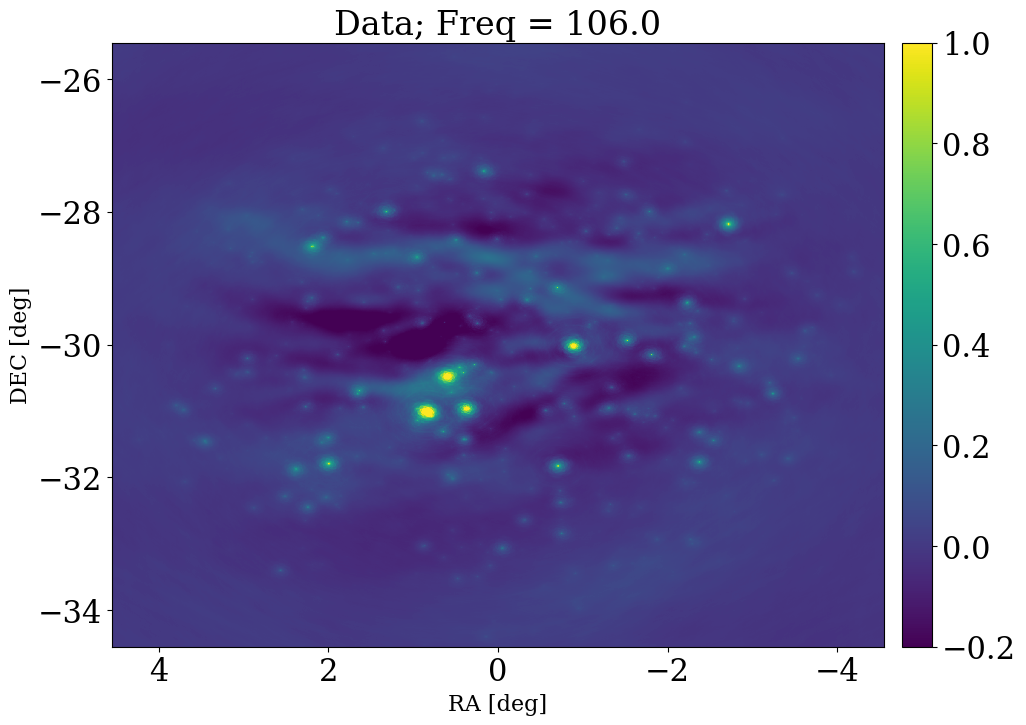

In [24]:
ext=(RA[0],RA[-1], DEC[0], DEC[-1])
imshow_kwargs = dict(aspect='auto', origin='lower', interpolation='nearest', 
                     extent=ext, )
plt.figure(figsize=(12,8),dpi=100)
nu_id = 0
im = plt.imshow(image[nu_id,:,:],vmin=-0.2,vmax=1,**imshow_kwargs)
plt.xlabel("RA [deg]",fontsize=16)
plt.ylabel('DEC [deg]',fontsize=16)
plt.title(f'Data; Freq = {freq[nu_id]/1e6}',fontsize=24)
plt.colorbar(orientation='vertical',pad=0.02)

In [25]:
# Load the primary beam 
path = '/project/def-mdobbs/arnab92/SKAD3/data/beam_Sub_bands'
beam = os.path.join(path,'SKA_beam_sub_1_106_120.9_MHz.fits')

In [26]:
hdu_beam = fits.open(beam)[0]

In [27]:
hdr_beam = hdu_beam.header

In [28]:
# hdr_beam

In [29]:
nfreq_beam = hdr_beam['NAXIS3']

In [30]:
beam = np.array(hdu_beam.data[:])

In [31]:
beam.shape,image.shape

((150, 2560, 2560), (150, 2048, 2048))

# Now take the beam of same shape as image
# Note that, the primary beam image is larger than the actual image
# This is what SKA group simulated

In [32]:
im_size_deg = abs(hdr['CDELT1']) * Nx # image size in deg
im_size_deg

9.102222222222213

In [33]:
# Make the beam image same as data image
theta_fov = im_size_deg # deg
res = abs(np.radians(hdr_beam['CDELT1']))
fov = np.radians(theta_fov)
fov_sin = 2 * np.sin(fov / 2.)

In [34]:
n = fov_sin / res
idx = int((beam.shape[1] - n) / 2.)-1
idx

256

In [35]:
# Trimmed central 4deg map
pb_map = beam[:, idx:-idx, idx:-idx]

In [36]:
pb_map.shape

(150, 2048, 2048)

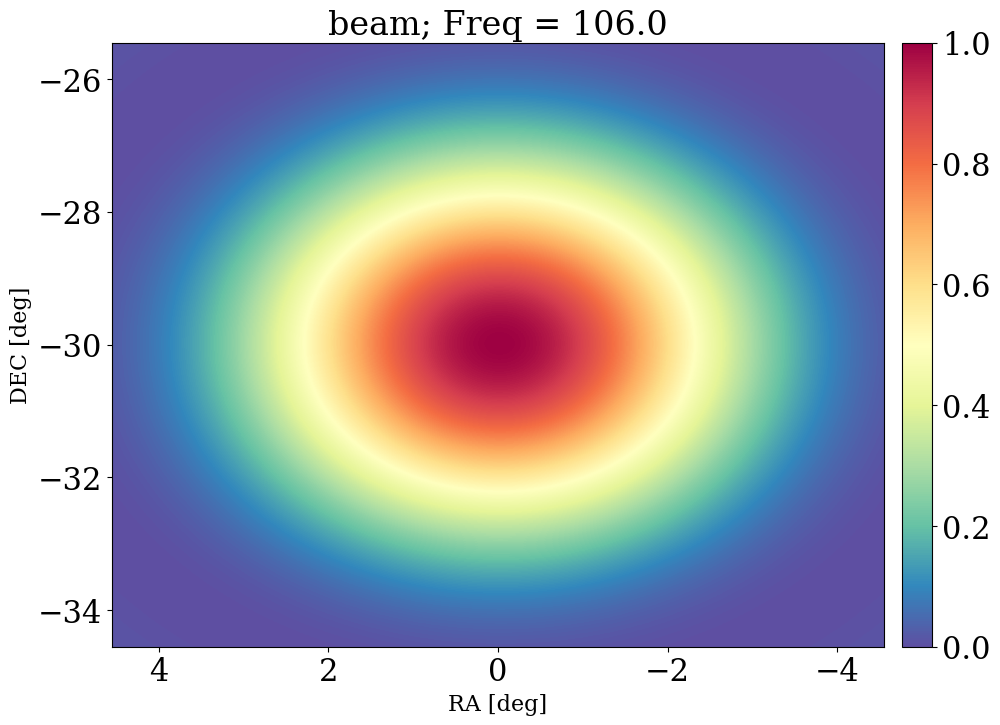

In [38]:
ext=(RA[0],RA[-1], DEC[0], DEC[-1])
imshow_kwargs = dict(aspect='auto', origin='lower', interpolation='nearest', 
                    extent=ext,  cmap='Spectral_r')

plt.figure(figsize=(12,8),dpi=100)
nu_id = 0
im = plt.imshow(pb_map[nu_id,:,:],**imshow_kwargs,vmin=0,vmax=1)
plt.xlabel("RA [deg]",fontsize=16)
plt.ylabel('DEC [deg]',fontsize=16)
plt.title(f'beam; Freq = {freq[nu_id]/1e6}',fontsize=24)
plt.colorbar(orientation='vertical',pad=0.02)

([], [])

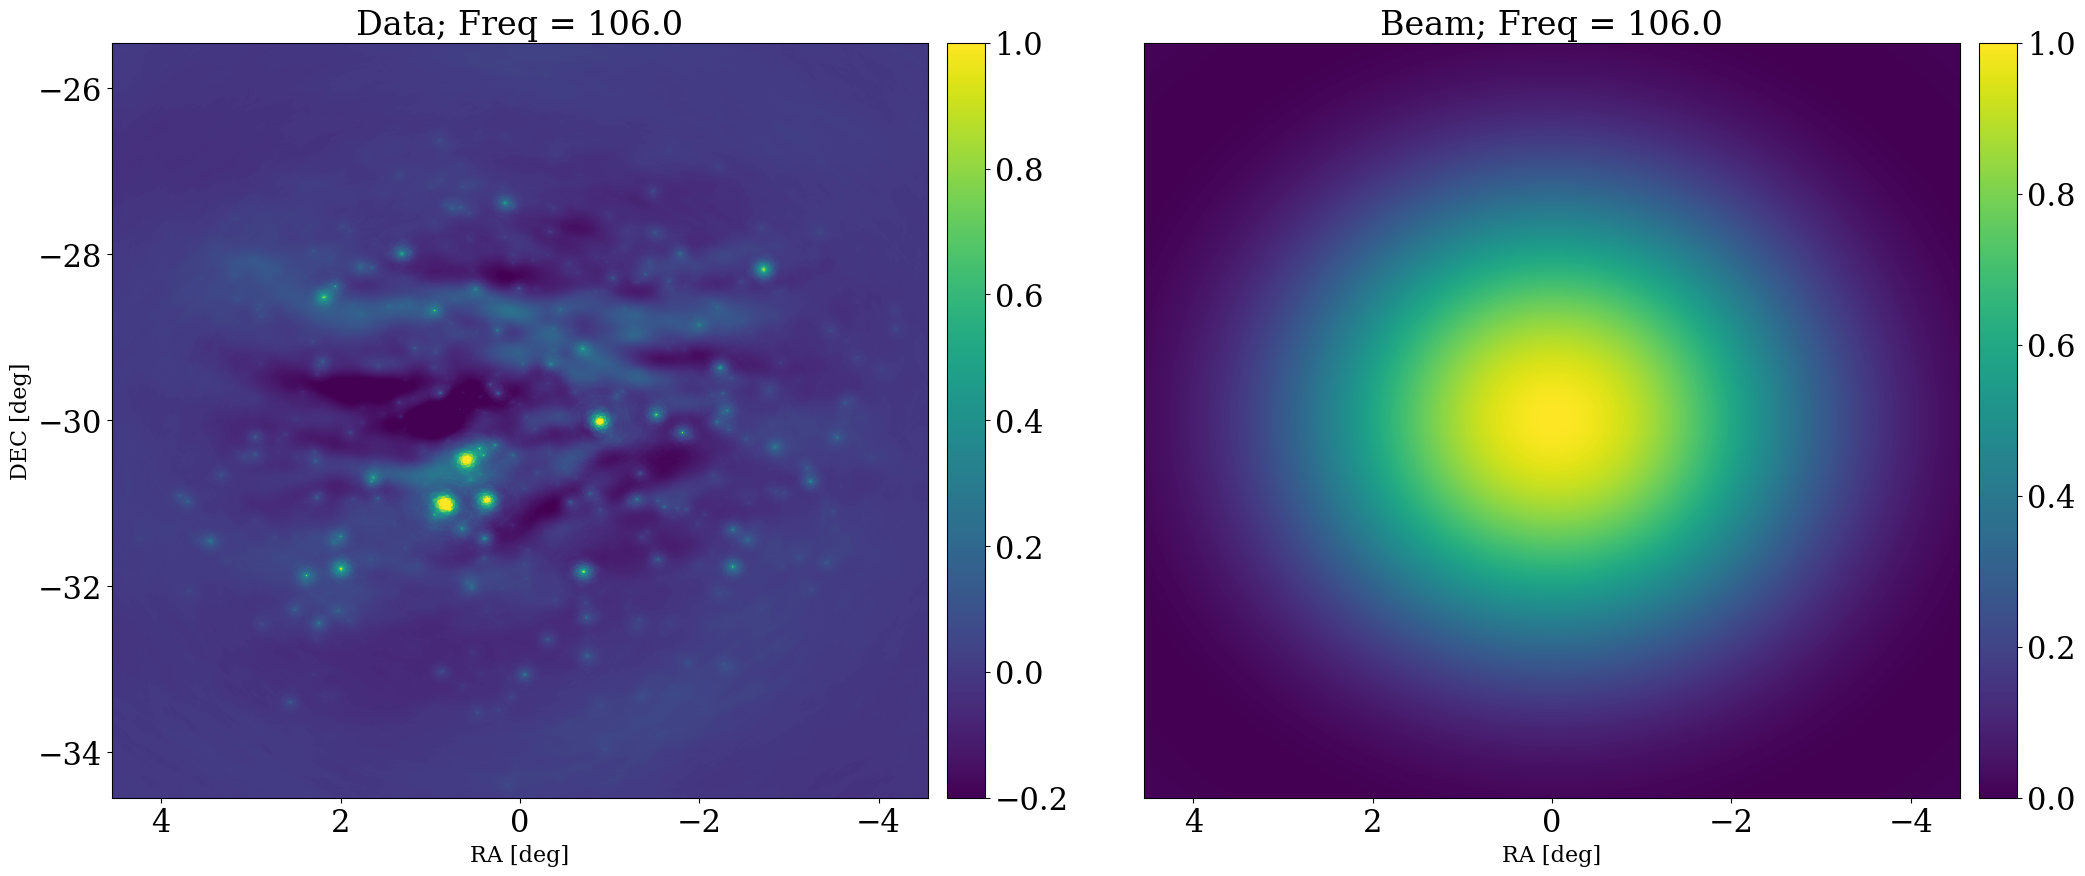

In [40]:
ext=(RA[0],RA[-1], DEC[0], DEC[-1])
imshow_kwargs = dict(aspect='auto', origin='lower', interpolation='nearest', 
                     extent=ext,)


fig = plt.figure(num=1, figsize=(26, 10), dpi=100)

gspec = gridspec.GridSpec(1, 2, wspace=0.05)
  
plt.subplot(gspec[0, 0])
plt.imshow(image[nu_id,:,:],vmin=-0.2,vmax=1,**imshow_kwargs)
plt.xlabel("RA [deg]",fontsize=16)
plt.ylabel('DEC [deg]',fontsize=16)
plt.title(f'Data; Freq = {freq[nu_id]/1e6}',fontsize=24)
plt.colorbar(orientation='vertical',pad=0.02)


plt.subplot(gspec[0, 1])
plt.imshow(pb_map[nu_id,:,:],vmin=0,vmax=1.0,**imshow_kwargs)
plt.xlabel("RA [deg]",fontsize=16)
plt.title(f'Beam; Freq = {freq[nu_id]/1e6}',fontsize=24)
plt.colorbar(orientation='vertical',pad=0.02)
plt.yticks([])

In [41]:
# Do the PB correction by dividing the beam
data_pb = np.divide(image,pb_map)

([], [])

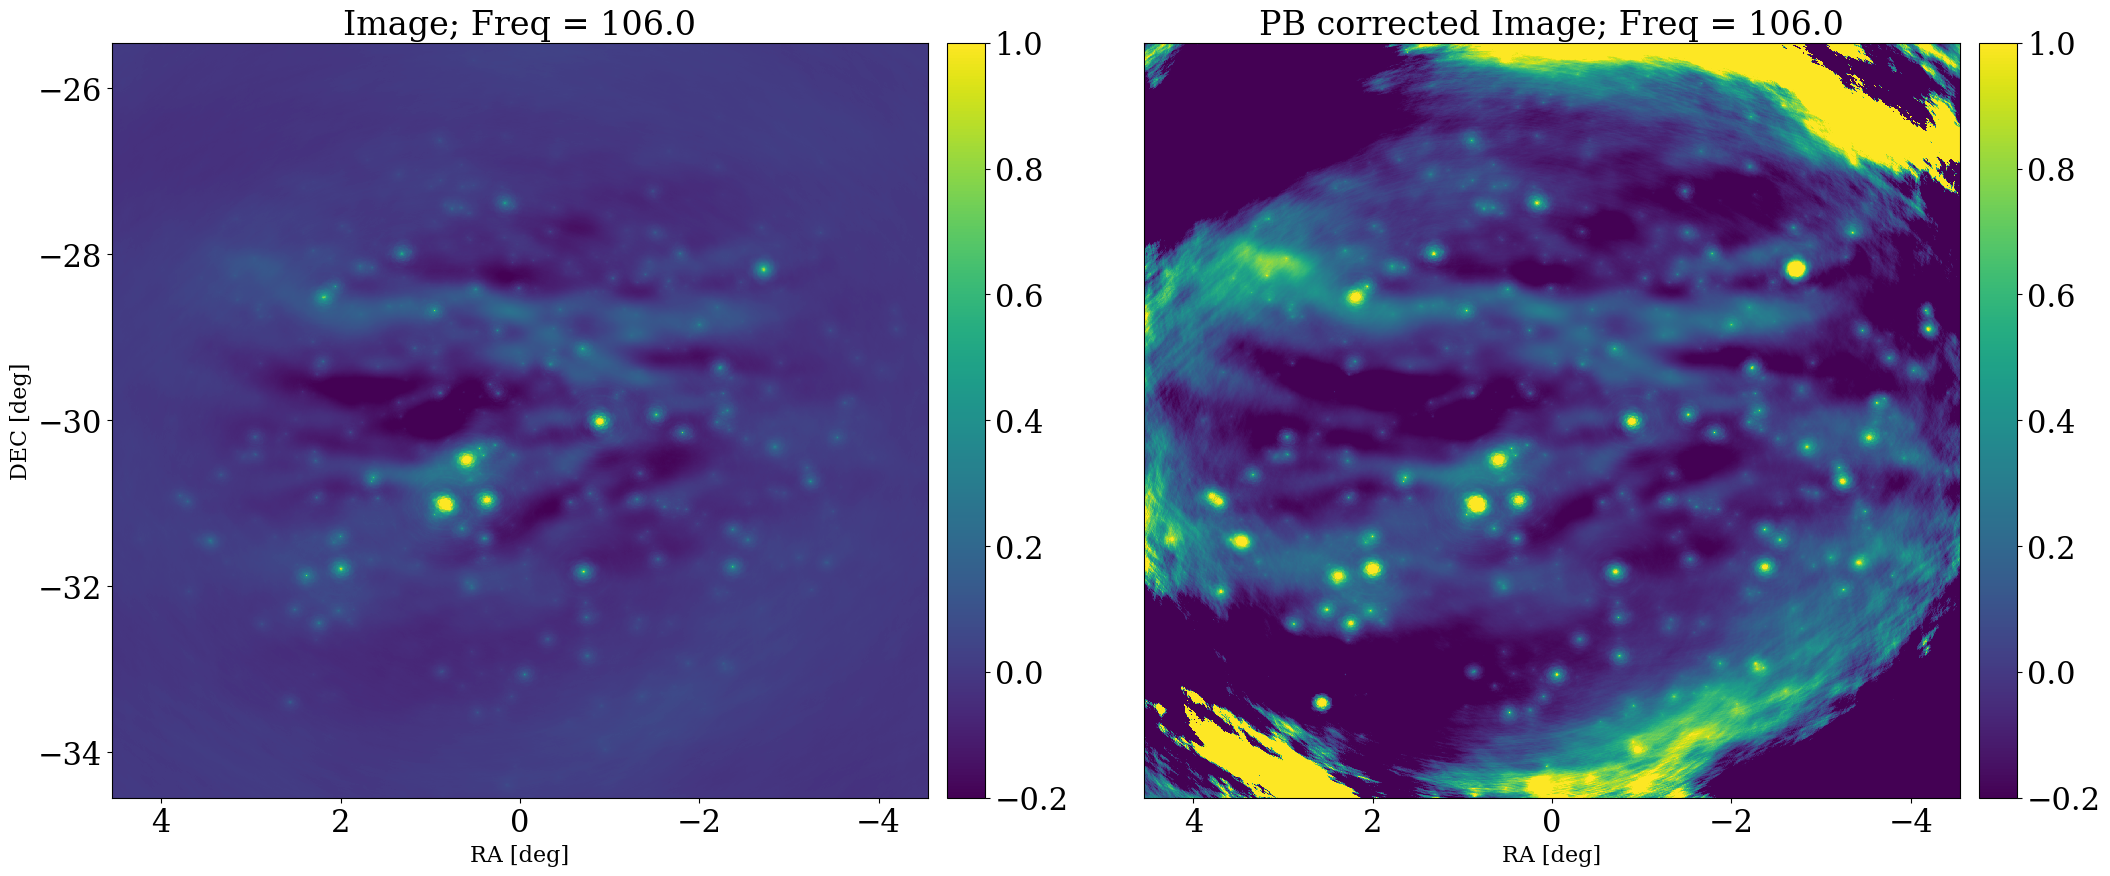

In [42]:
ext=(RA[0],RA[-1], DEC[0], DEC[-1])
imshow_kwargs = dict(aspect='auto', origin='lower', interpolation='nearest', 
                     extent=ext)


fig = plt.figure(num=1, figsize=(26, 10), dpi=100)

gspec = gridspec.GridSpec(1, 2, wspace=0.05)
  
plt.subplot(gspec[0, 0])
plt.imshow(image[nu_id,:,:],vmin=-0.2,vmax=1,**imshow_kwargs)
plt.xlabel("RA [deg]",fontsize=16)
plt.ylabel('DEC [deg]',fontsize=16)
plt.title(f'Image; Freq = {freq[nu_id]/1e6}',fontsize=24)
plt.colorbar(orientation='vertical',pad=0.02)


plt.subplot(gspec[0, 1])
plt.imshow(data_pb[nu_id,:,:],vmin=-0.2,vmax=1,**imshow_kwargs)
plt.xlabel("RA [deg]",fontsize=16)
plt.title(f'PB corrected Image; Freq = {freq[nu_id]/1e6}',fontsize=24)
plt.colorbar(orientation='vertical',pad=0.02)
plt.yticks([])

In [43]:
# Take the central 2 deg of the pb_corrected image to make the power spectrum
theta_fov = 2 # deg
res = abs(np.radians(hdr['CDELT1']))
fov = np.radians(theta_fov)
fov_sin = 2 * np.sin(fov / 2.)
n = fov_sin / res
idx = int((Nx - n) / 2.)
cart_map = data_pb[:, idx:-idx, idx:-idx]

In [44]:
# The 4 deg RA and DEC range
ra = RA[idx:-idx]
dec = DEC[idx:-idx]

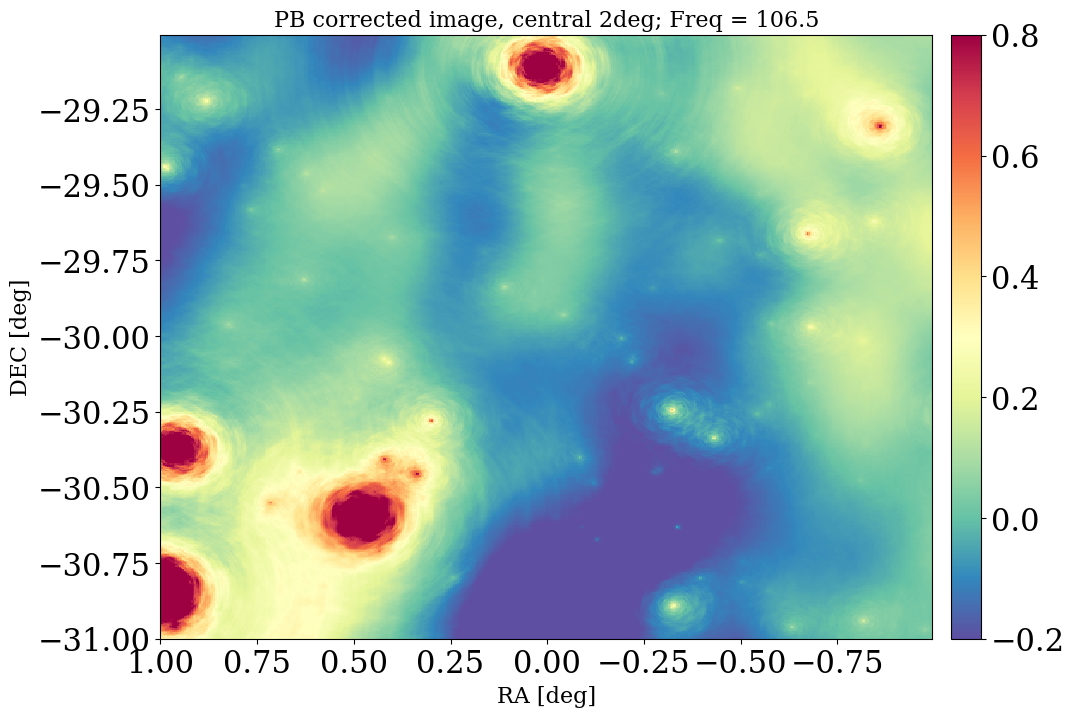

In [45]:
ext=(ra[0],ra[-1], dec[0], dec[-1])
imshow_kwargs = dict(aspect='auto', origin='lower', interpolation='nearest', 
                     extent=ext, cmap='Spectral_r')

nu_id = 5

plt.figure(figsize=(12,8),dpi=100)
im = plt.imshow(cart_map[nu_id,:,:].T,vmin=-0.2,vmax=0.8,**imshow_kwargs)
plt.xlabel("RA [deg]",fontsize=16)
plt.ylabel('DEC [deg]',fontsize=16)
plt.title(f'PB corrected image, central 2deg; Freq = {freq[nu_id]/1e6}',fontsize=16)
plt.colorbar(orientation='vertical',pad=0.02)

# Jy/beam to kelvin conversion

In [46]:
# Central freq and redshift
nu_c = freq[int(freq.size/2.0)]/1e6 # in MHz
print(f'The central freq is {nu_c} MHz')

wl = c/(nu_c*1e6) # nu_c is the freq of the map in MHz
print(f'The wavelength :  {wl} m')

redshift = f21.value/nu_c - 1
print('Redshift = ',redshift)

The central freq is 113.5 MHz
The wavelength :  2.641343242290749 m
Redshift =  11.514588123348016


In [47]:
bl_max = 2500. # Max baseline in m
PSF = wl/bl_max 
PSF_arcsec = np.degrees(PSF) * 3600 # in arcsec
print(f'The PSF size : {PSF_arcsec} arcsec')


The PSF size : 217.92646084127145 arcsec


In [48]:
omega_psf = (np.pi * PSF_arcsec**2)/((4*np.log(2)))# Bmaj=Bmin= PSF_arcsec;beam_area = (pi * Bmaj * Bmin)/(4 * log(2))
omega_psf_sr = (omega_psf*un.arcsec**2).to('sr')
print(f'PSF area ={omega_psf_sr}')


PSF area =1.2648356147000803e-06 sr


In [49]:
jybeam2k_factor = jy_per_beam_to_kelvin(freq/1e6,omega_psf_sr)
print(f'The mean conversion factor from Jy/bm to K at this freq is {np.mean(jybeam2k_factor)}')

The mean conversion factor from Jy/bm to K at this freq is 2008.1082610592866


In [50]:
# Check using BMAJ and BMIN
bmaj = hdr['BMAJ']
bmin = hdr['BMIN']
omega = np.radians(bmaj) * np.radians(bmin) * np.pi / (4 * np.log(2))
# imager_scale_factor = omega / (res ** 2)
print(omega)

7.862628953750243e-07


In [51]:
# Convert to kelvin 
cart_map_kelvin = cart_map * jybeam2k_factor[:,None,None]

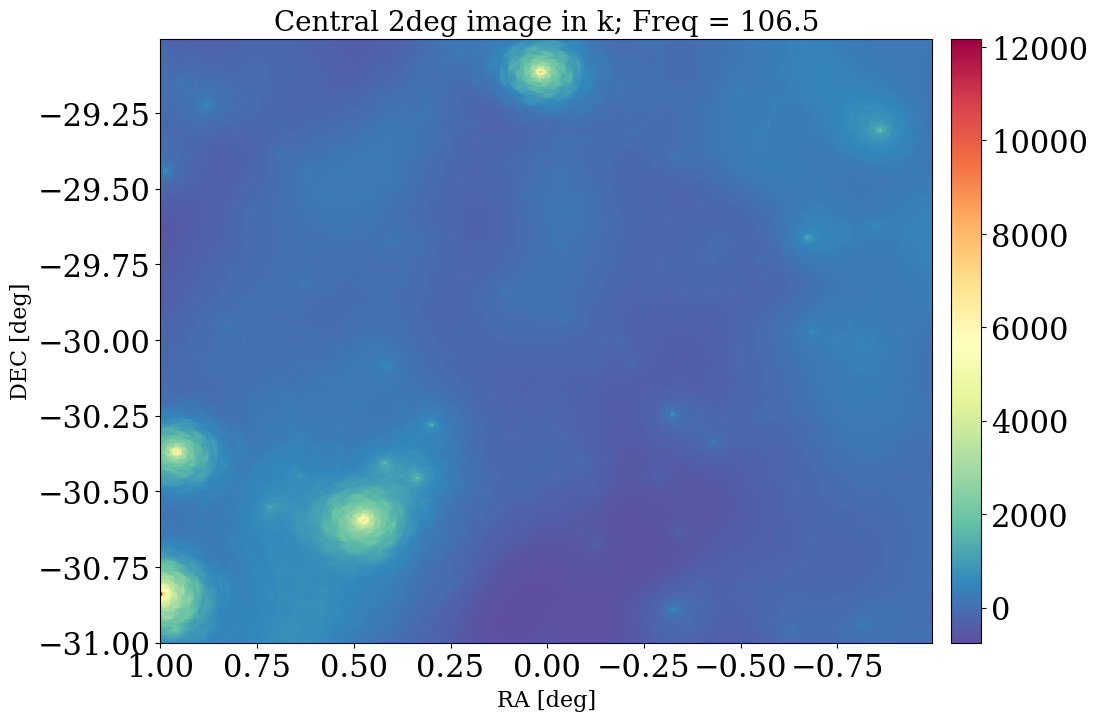

In [52]:
ext=(ra[0],ra[-1], dec[0], dec[-1])
imshow_kwargs = dict(aspect='auto', origin='lower', interpolation='nearest', 
                     extent=ext, cmap='Spectral_r')

nu_id = 5

plt.figure(figsize=(12,8),dpi=100)
im = plt.imshow(cart_map_kelvin[nu_id,:,:].T,**imshow_kwargs,)
plt.xlabel("RA [deg]",fontsize=16)
plt.ylabel('DEC [deg]',fontsize=16)
plt.title(f'Central 2deg image in k; Freq = {freq[nu_id]/1e6}',fontsize=20)
plt.colorbar(orientation='vertical',pad=0.02)

# Spatial Fourier Transform

In [53]:
apply_spatial_taper = True

In [54]:
# Transform to vis domain -- data
data_uv_nu = image_to_uv(cart_map_kelvin, window=False,axes=(1,2))

Fourier Norm : 4.938271604938272e-06


In [55]:
# # Transform to vis domain -- psf
# psf_uv_nu = image_to_uv(cart_psf, window=False,axes=(1,2))

In [56]:
# data_uv_nu.shape, psf_uv_nu.shape

In [57]:
# we are not normalizing by the psf in uv-domain as LOFAR does (Mertens+2020),
# we checked this for the test data. 
# so just dividing by 1 here.
with np.errstate(divide='ignore', invalid='ignore'):
      data = np.where(data_uv_nu != 0, np.divide(data_uv_nu, 1.0), 0)


<ipython-input-58-34a397852bc0>:7: RuntimeWarning: invalid value encountered in log10
  im = plt.imshow(np.log10(data[nu_id,:,:].real.T),**imshow_kwargs,)


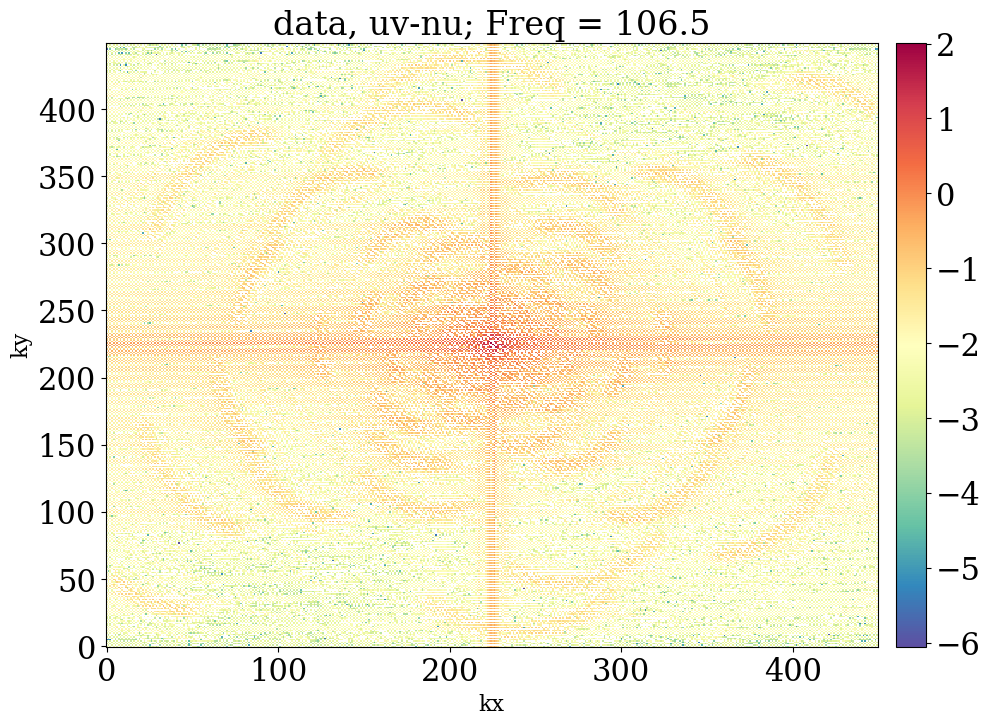

In [58]:
imshow_kwargs = dict(aspect='auto', origin='lower', interpolation='nearest', 
                      cmap='Spectral_r')

nu_id = 5

plt.figure(figsize=(12,8),dpi=100)
im = plt.imshow(np.log10(data[nu_id,:,:].real.T),**imshow_kwargs,)
plt.xlabel("kx",fontsize=16)
plt.ylabel('ky',fontsize=16)
plt.title(f'data, uv-nu; Freq = {freq[nu_id]/1e6}',fontsize=24)
plt.colorbar(orientation='vertical',pad=0.02)

# Delay Transform 

In [59]:
import scipy.signal.windows as windows

In [60]:
apply_spectral_window = True
window_name = 'nuttall'
nfreq= freq.size

In [61]:
if apply_spectral_window:
    
    # Generate a blackmanharris window to apodisation 
    window = windows.get_window(window_name,nfreq)
    w = window[:,np.newaxis,np.newaxis]
    
    data_uv_tau =  np.fft.fftshift(np.fft.ifft(data * w,axis=0),axes=0)    

else:
    data_uv_tau =  np.fft.fftshift(np.fft.ifft(data,axis=0),axes=0) 
     

In [62]:
delays = np.fft.fftshift(np.fft.fftfreq(nfreq, d= chan_res)) # * un.s # in s
tau = delays * 1e6 # in mu-s

In [63]:
# Estimating the k-modes ##
theta_res = np.deg2rad(abs(dx)) # pixel res (deg->rad), taking the mean resolution


In [64]:
print(theta_res,res)

7.757018897752568e-05 7.757018897752568e-05


In [65]:
# New shape of the trimmed 2deg image 
nx = data_uv_tau.shape[1]
ny = data_uv_tau.shape[2]

In [66]:
# get the Fourier modes
kx, ky, u, v = get_spatial_kmodes(nx,ny,theta_res,redshift)
k_perp = np.sqrt(kx[:,np.newaxis]**2 + ky[np.newaxis,:] **2)  # [Mpc^-1]

In [67]:
(wl * kperp_to_u(k_perp.max() * un.Mpc**-1,redshift))/1e3

<Quantity 24.07769973>

In [68]:
k_parallel = delay_to_kpara(delays * un.s,redshift,cosmo=cosmo)

Text(0, 0.5, 'Data [K]')

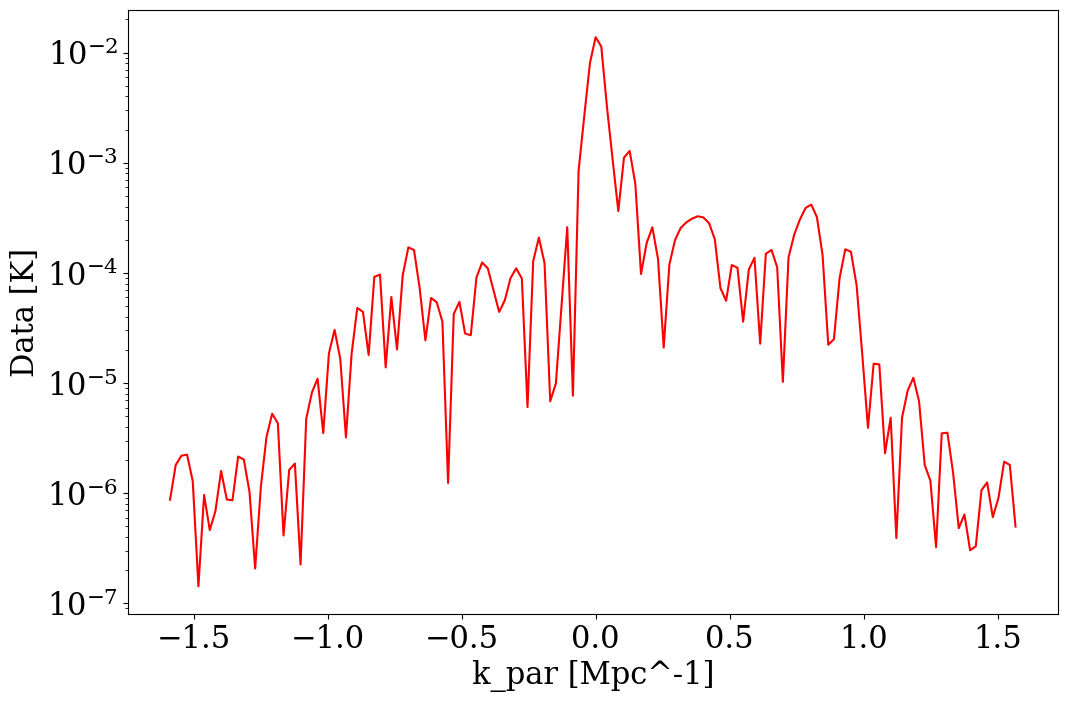

In [69]:
plt.figure(figsize=(12,8),dpi=100)
plt.plot(k_parallel.value, abs(data_uv_tau[:,100,100].real),color='red')

plt.yscale('log')
plt.xlabel(r'k_par [Mpc^-1]')
plt.ylabel(r'Data [K]')
# plt.axvline(0.2)
#plt.xlim(-2,2)

<ipython-input-76-0c491689fc0b>:7: RuntimeWarning: invalid value encountered in log10
  im = plt.imshow(np.log10(data_uv_tau[delay_id,:,:].real),


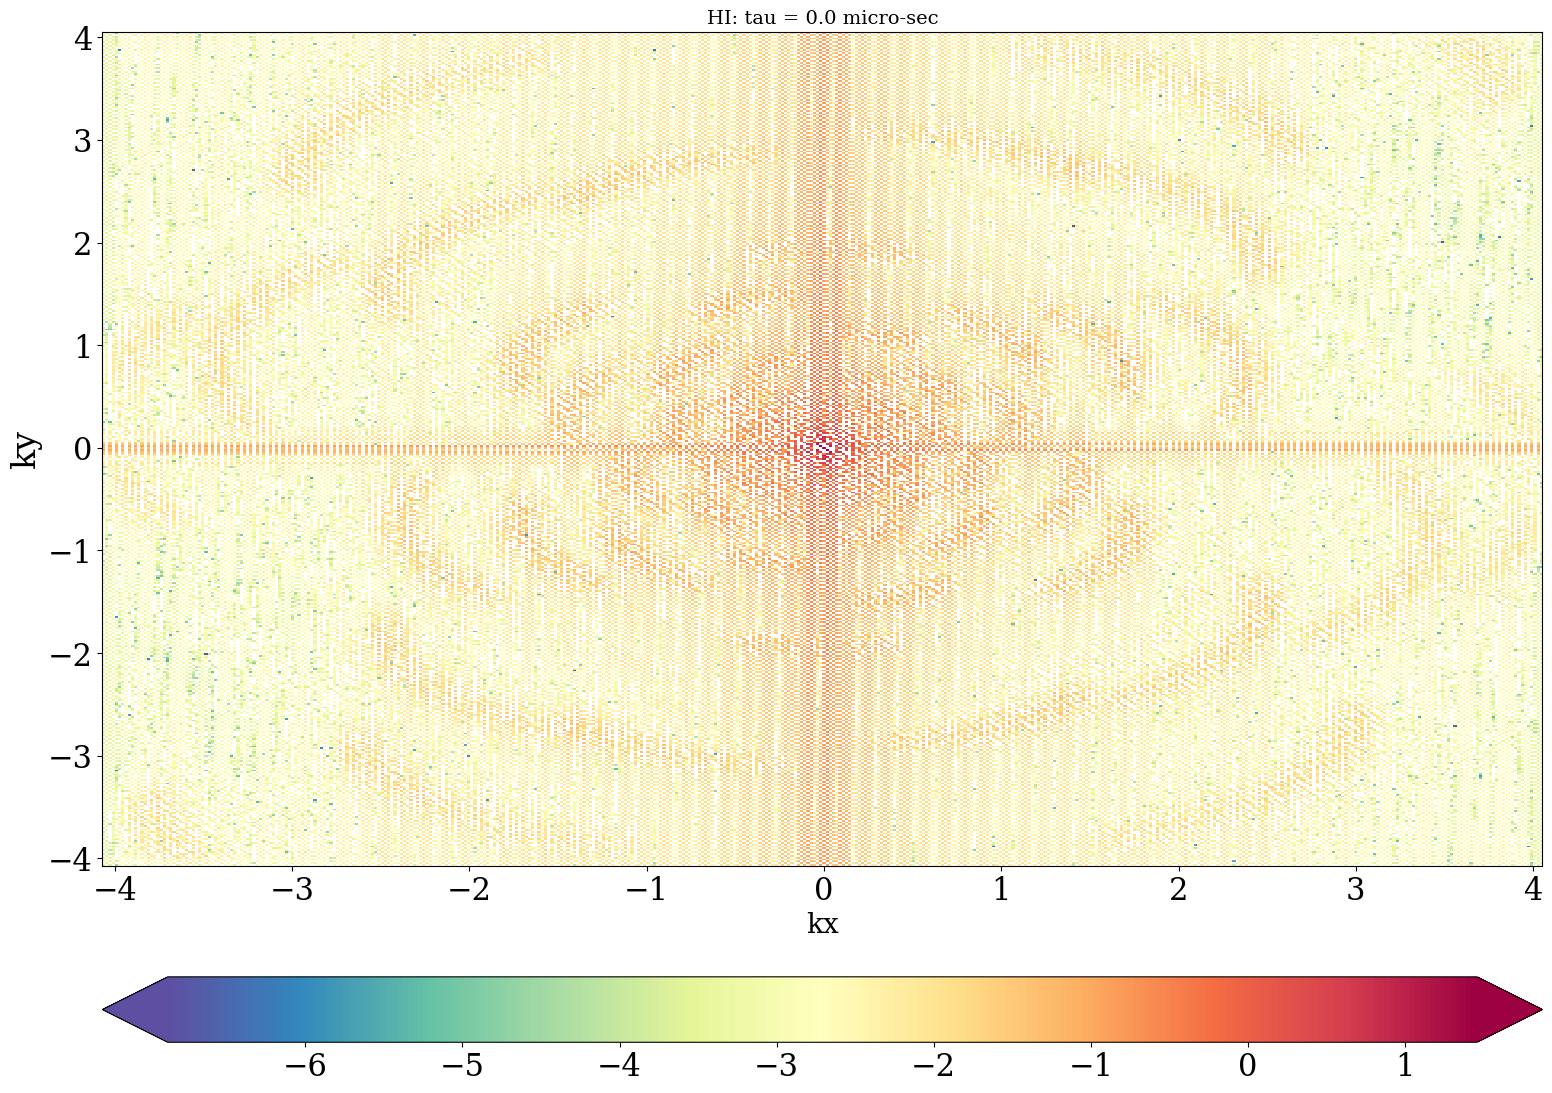

In [76]:
tau_id = np.argmin(abs(tau-0.))
tau_id
delay_id = tau_id

fig = plt.figure(figsize=(16, 12), dpi=100)

im = plt.imshow(np.log10(data_uv_tau[delay_id,:,:].real),
                   extent=(kx[0],kx[-1], ky[0], ky[-1]),
                aspect='auto', origin='lower', interpolation='nearest',cmap='Spectral_r')



plt.colorbar(im, extend='both',pad=0.1, orientation='horizontal')
#cbar0.ax.minorticks_off()



plt.xlabel(r'kx',fontsize=20)
plt.ylabel(r'ky',fontsize=24)
plt.title(f'HI: tau = {np.round(tau[delay_id],2)} micro-sec',fontsize=14)

plt.tight_layout()
plt.show()

In [71]:
dfreq = chan_res/1e6 # chan res in MHz
f21.value

1420.405752

In [72]:
# The volume normalization
vol_norm = vol_normalization_vis(Nx = nx, Ny = ny, Nz = nfreq, 
                                      theta_res = theta_res, redshift=redshift,chan_width = dfreq)

Linear size in X-direction = 347.26401934013825 Mpc
Linear size in Y-direction = 347.26401934013825 Mpc
Linear size in Z-direction = 296.8231032968922 Mpc
Power Spectrum normalization factor  value - 35794580.46095959 Mpc^3


In [74]:
# Take the 3D correlation, (auto-ps), and normalize by the volume of the survey. We take the real part only.
data_corr_real = get_ps(data_uv_tau,vis_cube_2=data_uv_tau,vol_norm_factor=vol_norm)

correlate the vis cube 1 with vis cube 2


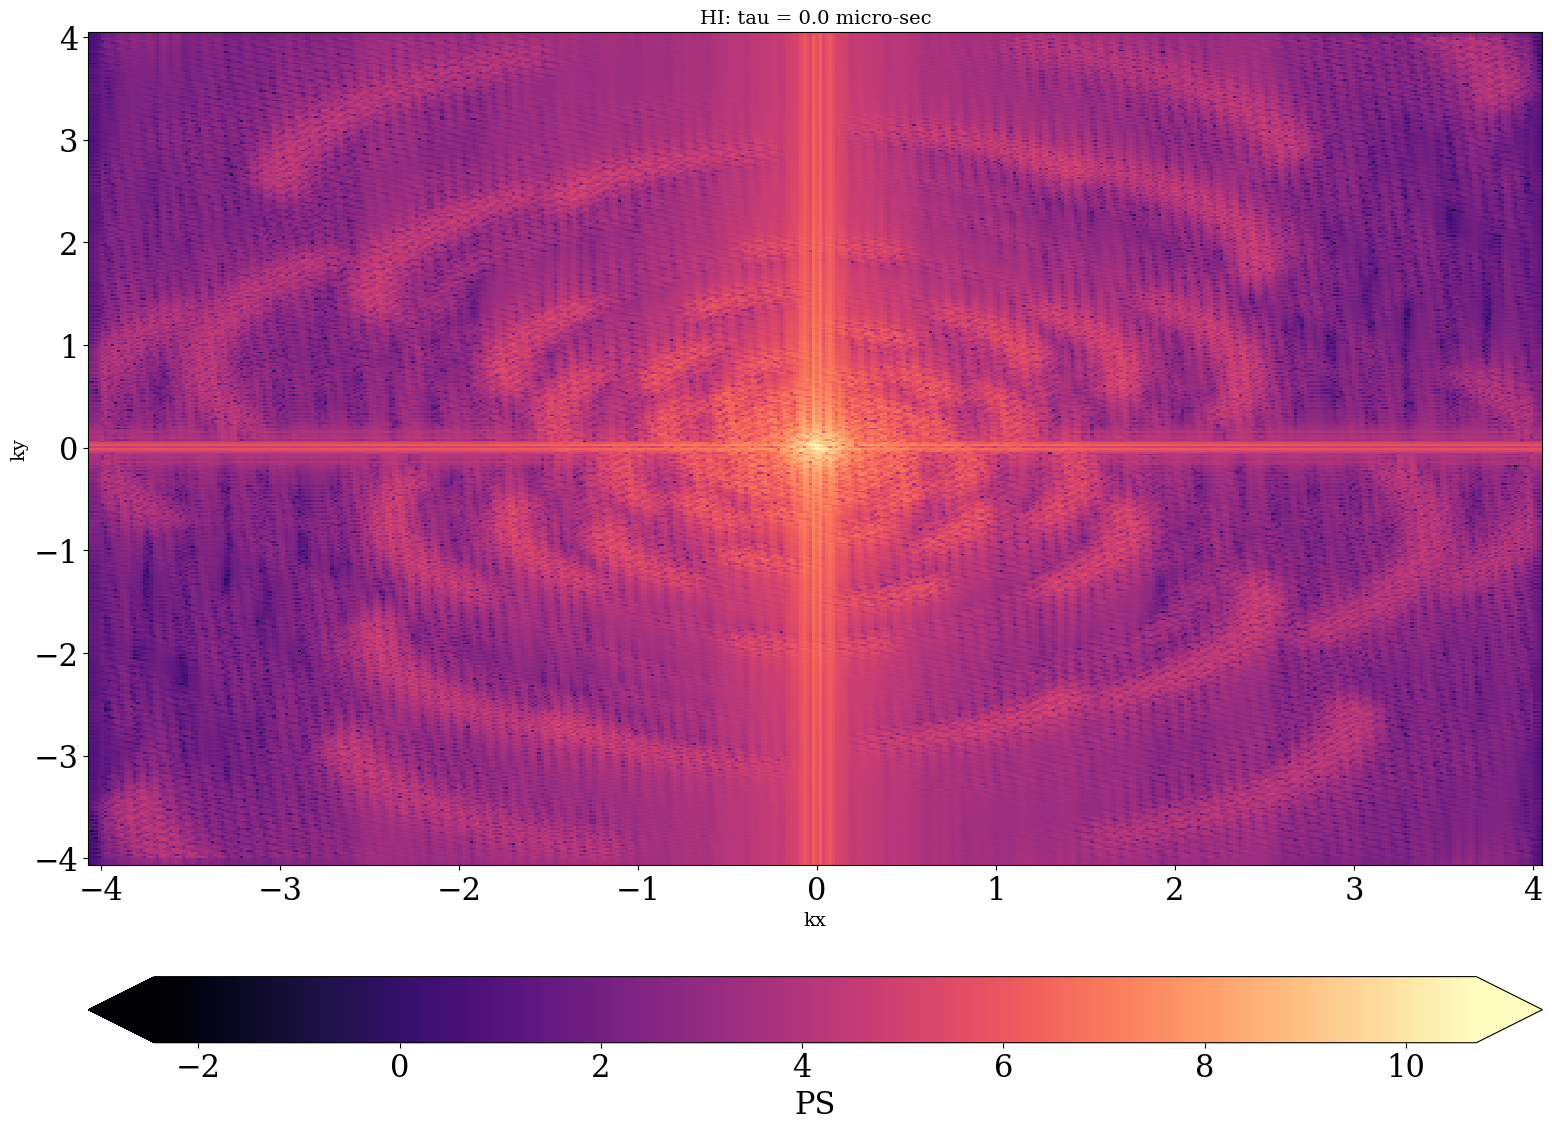

In [75]:
delay_id = tau_id

fig = plt.figure(figsize=(16, 12), dpi=100)

im = plt.imshow(np.log10(data_corr_real[delay_id,:,:]),
                   extent=(kx[0],kx[-1], ky[0], ky[-1]),
                aspect='auto', origin='lower', interpolation='nearest',cmap='magma')
plt.colorbar(im, extend='both',pad=0.1, orientation='horizontal',label='PS')
plt.xlabel(r'kx',fontsize=14)
plt.ylabel(r'ky',fontsize=14)
plt.title(f'HI: tau = {np.round(tau[delay_id],2)} micro-sec',fontsize=14)
# plt.ylim(-2,2)
# plt.xlim(-2,2)
plt.tight_layout()
plt.show()

In [77]:
# SKA baselines
u_min = 40.0 #m
u_max = 2500.0 #m 
u_min_lambda = u_min/wl; u_max_lambda = u_max/wl
kperp_min = u_to_kperp(u_min_lambda,redshift,cosmo=cosmo)
kperp_max = u_to_kperp(u_max_lambda,redshift,cosmo=cosmo)

print(f'Min baseline: {u_min} m, Max baseline: {u_max} m,z: {redshift}, Wavelength:{wl} m')
print(f'Min bl in wavelength unit: {u_min_lambda},Max bl: {u_max_lambda}')
print(f'Min kperp: {kperp_min}, Max kperp: {kperp_max}')   

Min baseline: 40.0 m, Max baseline: 2500.0 m,z: 11.514588123348016, Wavelength:2.641343242290749 m
Min bl in wavelength unit: 15.143809921996104,Max bl: 946.4881201247565
Min kperp: 0.009564507101311537 1 / Mpc, Max kperp: 0.5977816938319711 1 / Mpc


In [78]:
# keep the non-zero visibilities between minimum and maximum baseline for each delay channel
# also, take the flatten array; i.e, the out put is (ntau,nvis),
# where nvis is number of vis between two limit 
data_corr, uu, vv,  = reshape_data_cube(data_corr_real,u,v,u_min_lambda, u_max_lambda)

Gridded data cube shape in kx and ky direction - (450, 450)


In [ ]:
# Nbins_2D= 10 # Number of 2D bins 
# logbins_2D=False


In [80]:
# The true kperp and kpar bins, provided by SKA group
kperp_bins = np.loadtxt(os.path.join("/project/def-mdobbs/arnab92/SKAD3/test_data","bins_kper.txt"))
kpar_bins = np.loadtxt(os.path.join("/project/def-mdobbs/arnab92/SKAD3/test_data","bins_kpar.txt"))

In [81]:
kperp_bins.min(),kperp_bins.max()

(0.05, 0.5)

In [82]:
kperp,kl,ps_2D,ps_2D_w,ps_2D_err  = PS2D(data_corr,weight_cube=None,kperp_bins=kperp_bins,
                                    kpar_bins=kpar_bins,
                                    kpar=k_parallel.value, uu = uu, vv = vv,redshift=redshift,
                                    )

Using unit uniform weighting
(3424,)


In [83]:
# Here do the coarse binning along k_perp and no bin along k_par, to see small scale features
k_perp,k_par,ps2D,_,_ = PS2D_no_kpar_bin(data_corr,weight_cube=None,
                    kperp_min=kperp_min.value,kperp_max=kperp_max.value,kpar=k_parallel.value,
                    uu=uu,vv=vv,redshift=redshift,fold=True,
                    Nbins_2D=50,log_bins=False)

Using unit uniform weighting
Using linear binning in k_perp between 0.009564507101311537 and 0.5977816938319711
(3424,)


In [84]:
kperp.min(),kperp.max(),k_perp.min(),k_perp.max()

(0.05, 0.5, 0.009564507101311537, 0.5977816938319711)

In [85]:
kl[kl>0].min(),kl.max(),k_par.min(),k_par.max()

(0.05, 0.5, 0.02116811406319318, 1.5664404406762953)

In [86]:
kbins = np.sqrt(kl[np.newaxis,:]**2+kperp[:,np.newaxis]**2)
kbins.shape

(10, 10)

In [ ]:
fig, ax = plt.subplots(1, figsize=(12, 10), dpi=120)

im = ax.pcolormesh(kperp, kpar_bins, np.log10((ps_2D*1e6)),cmap = 'Spectral_r')


cbar = fig.colorbar(im, ax=ax, extend='both',pad=0.1, orientation='horizontal')

cbar.ax.minorticks_off()

cbar.set_label(r'P$_{k}$ [mK$^{2}$ Mpc$^{3}$]')
#ax.set_xscale('log')
plt.title('Estimated PS')
ax.set_xlabel(r'$k_{\perp} [Mpc^{-1}]$')
ax.set_ylabel(r'$k_{\parallel} [Mpc^{-1}]$')
plt.tight_layout()
plt.show()

<ipython-input-87-b19ef7004107>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(k_perp, k_par, np.log10((ps2D*1e6)),cmap = 'Spectral_r')


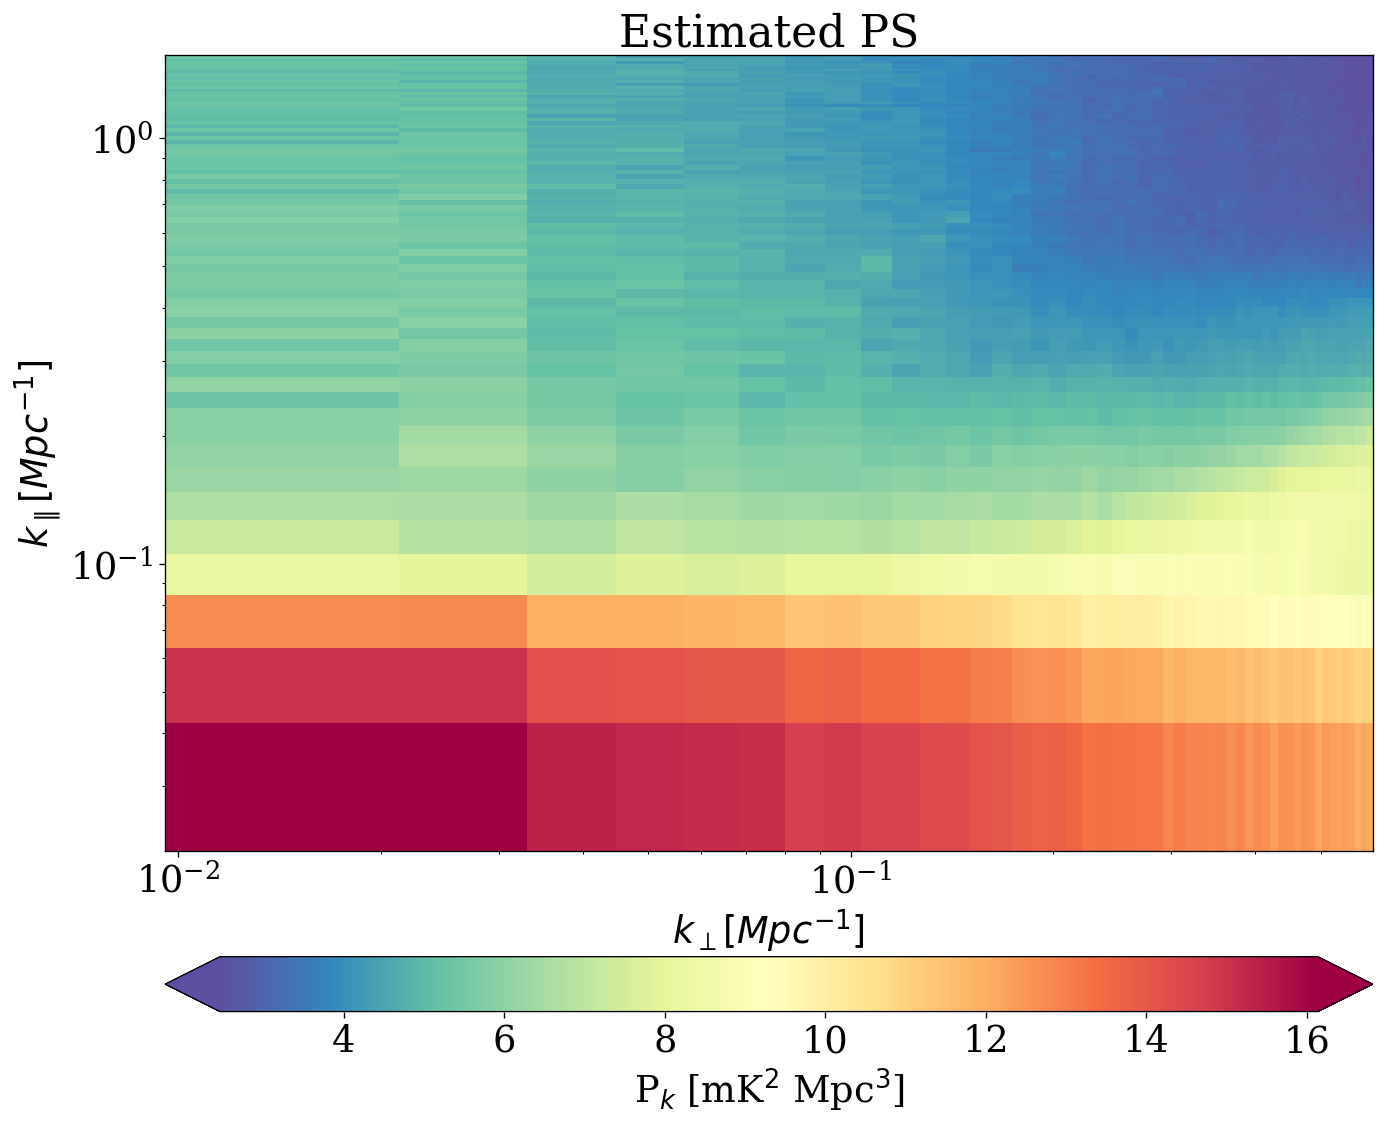

In [87]:
fig, ax = plt.subplots(1, figsize=(12, 10), dpi=120)

im = ax.pcolormesh(k_perp, k_par, np.log10((ps2D*1e6)),cmap = 'Spectral_r')


cbar = fig.colorbar(im, ax=ax, extend='both',pad=0.1, orientation='horizontal')

cbar.ax.minorticks_off()

cbar.set_label(r'P$_{k}$ [mK$^{2}$ Mpc$^{3}$]')
ax.set_xscale('log')
ax.set_yscale('log')
plt.title('Estimated PS')
ax.set_xlabel(r'$k_{\perp} [Mpc^{-1}]$')
ax.set_ylabel(r'$k_{\parallel} [Mpc^{-1}]$')
plt.tight_layout()
plt.show()

In [88]:
def k_to_delay(k, z, unit=un.Mpc):
    '''Convert delay to inverse co-moving distance in h Mpc^-1 '''
    return k * freqency_to_comoving_distance(z, unit=unit) / (2 * np.pi)

def freqency_to_comoving_distance(z, unit=un.Mpc):
    '''Return frequency to co-moving distance conversion factor'''
    return ((const.c * (1 + z) ** 2) / (cosmo.H(z) * f21)).to(unit * un.Hz ** -1).value 

def delay_to_k(delay, z, unit=un.Mpc):
    '''Convert delay to inverse co-moving distance in h Mpc^-1 '''
    return 2 * np.pi * delay / freqency_to_comoving_distance(z, unit=unit)


In [89]:
tau_horizon = k_to_delay(k_perp,redshift)
kpar_horizon_100ns_buffer = delay_to_kpara((tau_horizon+100e-9) * un.s,redshift).value
kpar_horizon = delay_to_kpara(tau_horizon * un.s,redshift).value


In [90]:
kpar_horizon

array([0.00956451, 0.02132885, 0.03309319, 0.04485754, 0.05662188,
       0.06838623, 0.08015057, 0.09191491, 0.10367926, 0.1154436 ,
       0.12720794, 0.13897229, 0.15073663, 0.16250098, 0.17426532,
       0.18602966, 0.19779401, 0.20955835, 0.22132269, 0.23308704,
       0.24485138, 0.25661573, 0.26838007, 0.28014441, 0.29190876,
       0.3036731 , 0.31543744, 0.32720179, 0.33896613, 0.35073048,
       0.36249482, 0.37425916, 0.38602351, 0.39778785, 0.40955219,
       0.42131654, 0.43308088, 0.44484523, 0.45660957, 0.46837391,
       0.48013826, 0.4919026 , 0.50366694, 0.51543129, 0.52719563,
       0.53895998, 0.55072432, 0.56248866, 0.57425301, 0.58601735,
       0.59778169])

<ipython-input-91-cc55a7f9f3fc>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(k_perp, k_par, np.log10((ps2D*1e6)),cmap = 'Spectral_r')


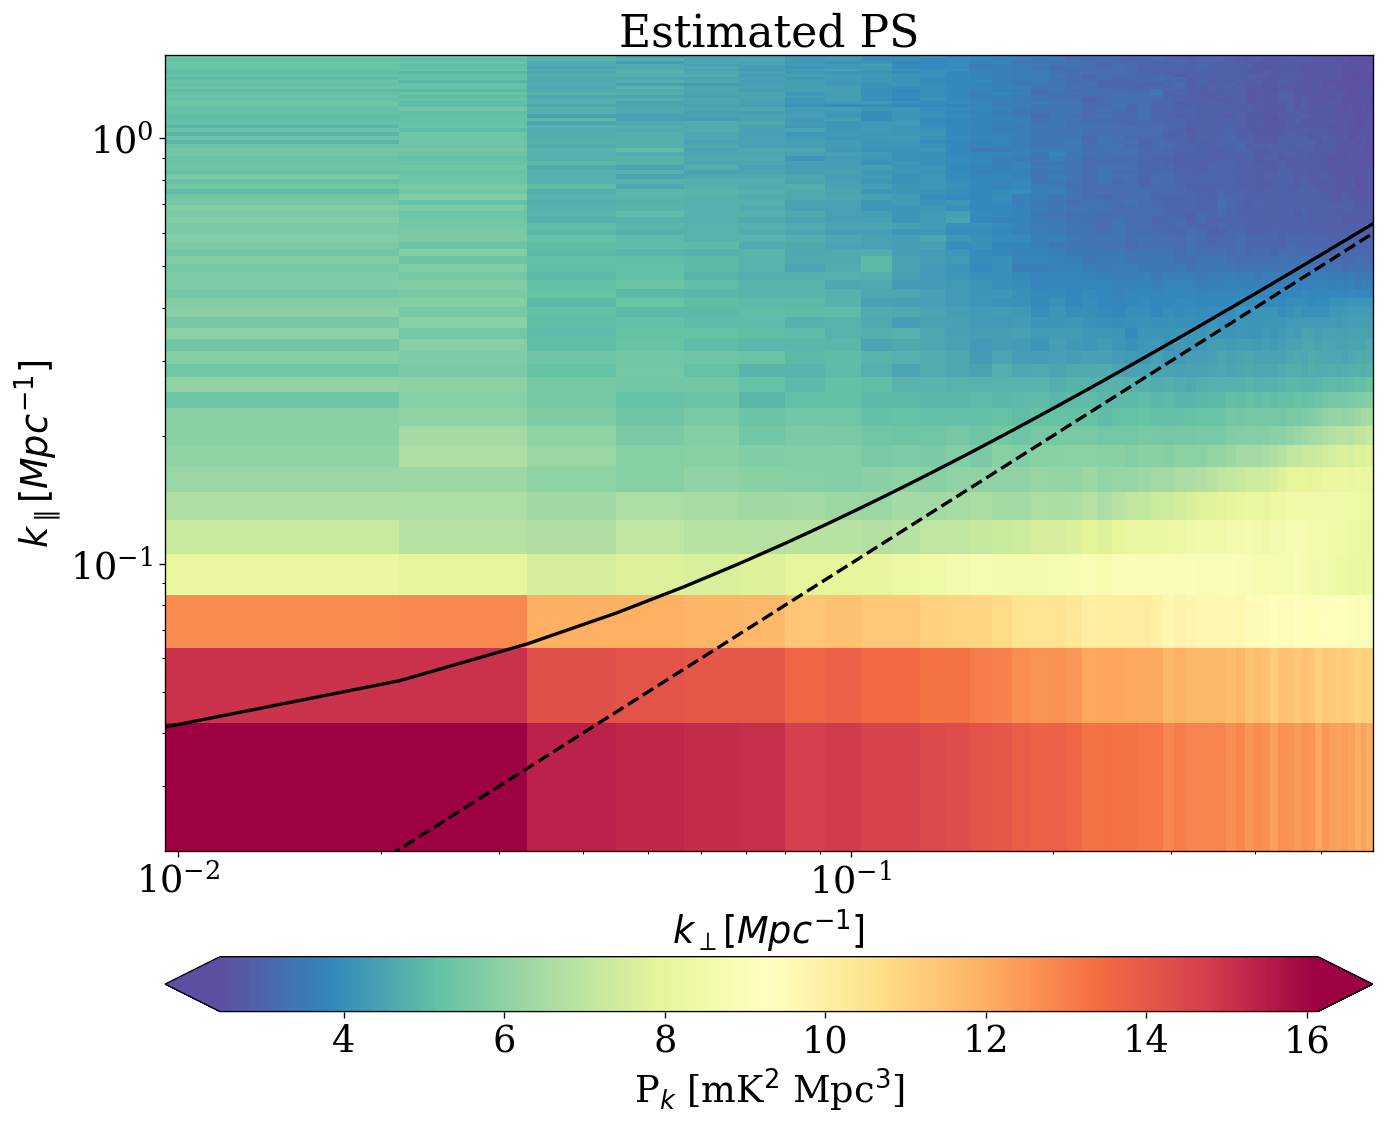

In [91]:
fig, ax = plt.subplots(1, figsize=(12, 10), dpi=120)

im = ax.pcolormesh(k_perp, k_par, np.log10((ps2D*1e6)),cmap = 'Spectral_r')

plt.plot(k_perp,kpar_horizon_100ns_buffer,color='black',lw=2)
plt.plot(k_perp,kpar_horizon,color='black',lw=2,linestyle='--')

cbar = fig.colorbar(im, ax=ax, extend='both',pad=0.1, orientation='horizontal')

cbar.ax.minorticks_off()

cbar.set_label(r'P$_{k}$ [mK$^{2}$ Mpc$^{3}$]')
ax.set_xscale('log')
ax.set_yscale('log')
plt.title('Estimated PS')
ax.set_xlabel(r'$k_{\perp} [Mpc^{-1}]$')
ax.set_ylabel(r'$k_{\parallel} [Mpc^{-1}]$')
plt.ylim(k_par.min(),k_par.max())
plt.tight_layout()
plt.show()

In [ ]:
# ## Saving the pse ## 
# with h5py.File('/home/arnab92/notebooks/SKAD3/PS2D_166MHz_181MHz_data.h5','w') as hf:
#     PS2D = hf.create_dataset('ps_2D',data=ps2D,shape=ps2D.shape)
#     kperp = hf.create_dataset('k_perp',data=k_perp,shape=k_perp.shape)
#     kpara = hf.create_dataset('k_par',data=k_par,shape=k_par.shape)
#     freq = hf.create_dataset('freq',data=freq_sub,shape=freq_sub.shape)
#     redshit = hf.create_dataset('z',data=redshift)

In [92]:
# True ps provided by SKA group, this is at higher freq, but still do the comparison
ps = np.loadtxt(os.path.join("/project/def-mdobbs/arnab92/SKAD3/test_data","TestDatasetTRUTH_166MHz-181MHz.data"))

<ipython-input-93-99bd4fe06fac>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(kperp_bins, kpar_bins, np.log10((ps*1e6)),cmap = 'Spectral_r')


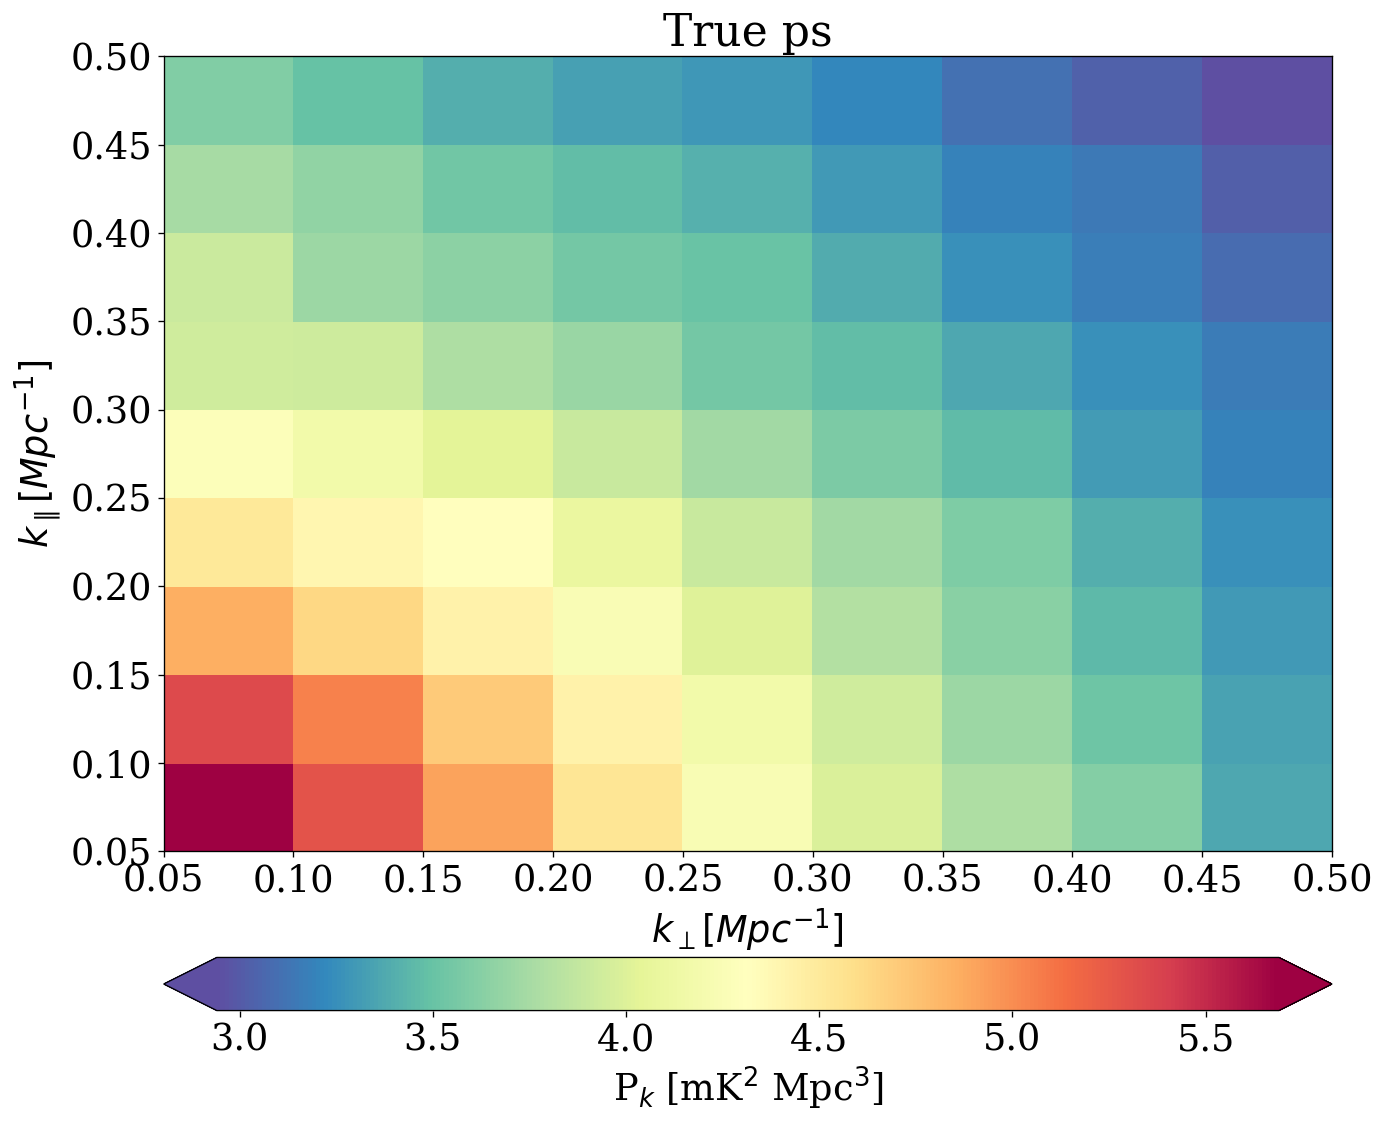

In [93]:
fig, ax = plt.subplots(1, figsize=(12, 10), dpi=120)

im = ax.pcolormesh(kperp_bins, kpar_bins, np.log10((ps*1e6)),cmap = 'Spectral_r')


cbar = fig.colorbar(im, ax=ax, extend='both',pad=0.1, orientation='horizontal')

cbar.ax.minorticks_off()

cbar.set_label(r'P$_{k}$ [mK$^{2}$ Mpc$^{3}$]')
#ax.set_xscale('log')
plt.title('True ps')
ax.set_xlabel(r'$k_{\perp} [Mpc^{-1}]$')
ax.set_ylabel(r'$k_{\parallel} [Mpc^{-1}]$')
plt.tight_layout()
plt.show()

In [94]:
import matplotlib.gridspec as gridspec

<ipython-input-95-be0d0a60fd41>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(kperp, kpar_bins, np.log10((ps_2D*1e6)),cmap = 'Spectral_r')
<ipython-input-95-be0d0a60fd41>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(kperp_bins, kpar_bins, np.log10((ps*1e6)),cmap = 'Spectral_r')


Text(0.5, 1.0, 'True')

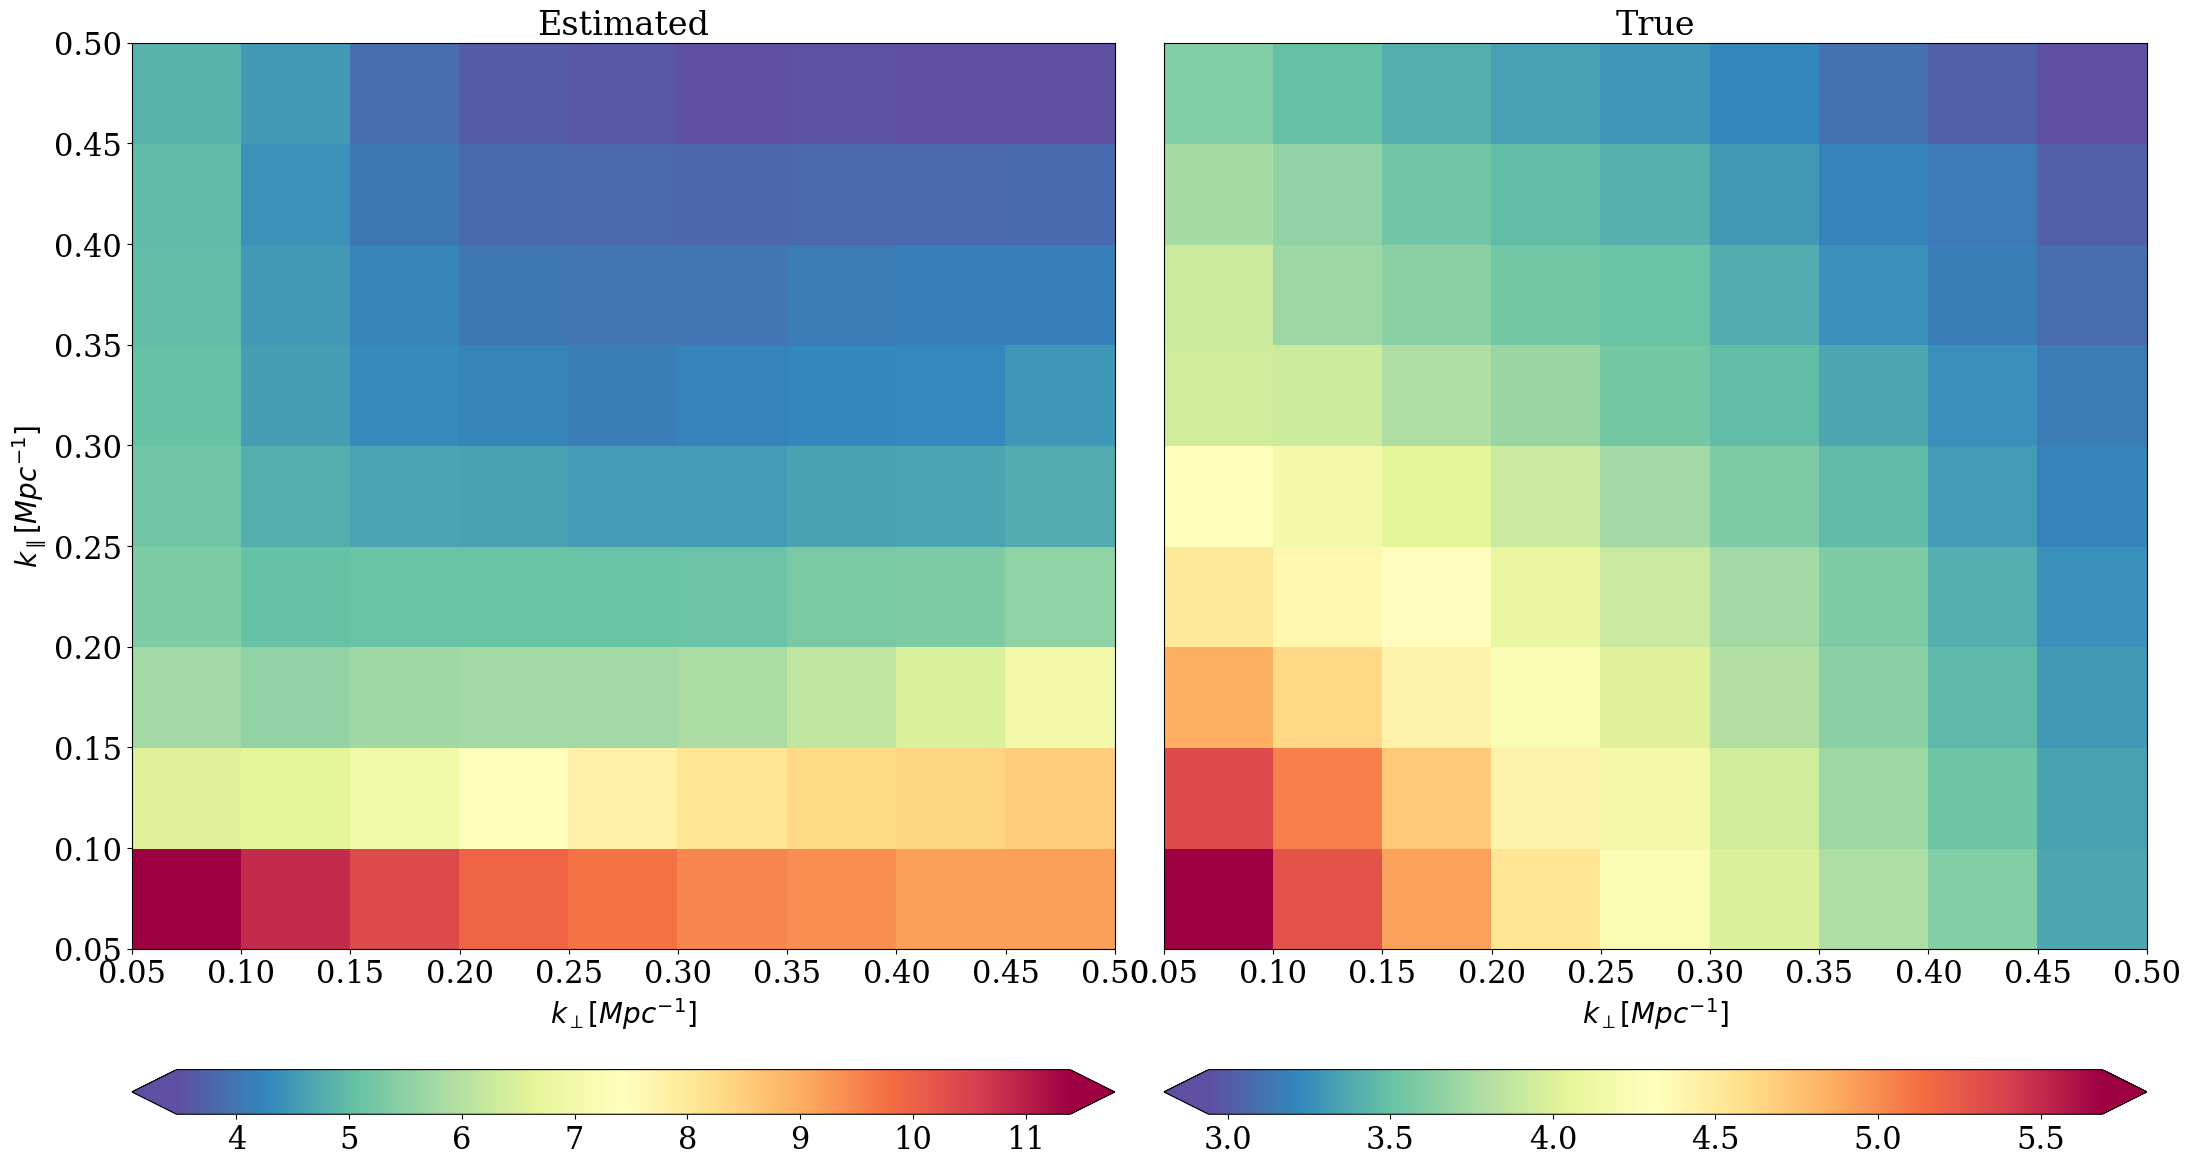

In [95]:
fig = plt.figure(num=1, figsize=(26, 16), dpi=100)

gspec = gridspec.GridSpec(1, 2, wspace=0.05)
  
plt.subplot(gspec[0, 0])
plt.pcolormesh(kperp, kpar_bins, np.log10((ps_2D*1e6)),cmap = 'Spectral_r')
plt.colorbar(extend='both',pad=0.1,orientation='horizontal')
plt.ylabel(r'$k_{\parallel} [Mpc^{-1}]$',fontsize=20)
plt.title(f'Estimated',fontsize=24)
plt.xlabel(r'$k_{\perp} [Mpc^{-1}]$',fontsize=20)


plt.subplot(gspec[0, 1])
plt.pcolormesh(kperp_bins, kpar_bins, np.log10((ps*1e6)),cmap = 'Spectral_r')
plt.colorbar(extend='both',pad=0.1,orientation='horizontal')
plt.yticks([])
plt.xlabel(r'$k_{\perp} [Mpc^{-1}]$',fontsize=20)
plt.title(f'True',fontsize=24)
